In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.utils import *
from lib.lip_model import *
from lib.knn import KNNL2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
exp_id = 2

# model_name = 'train_mnist_exp%d.h5' % exp_id
# net = BasicModel()

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=1000)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'lip_mnist_exp%d.h5' % exp_id
# net = LipschitzModel()

# model_name = 'dist_mnist_exp%d.h5' % exp_id
# net = NeighborModel()

model_name = 'adv_mnist_exp%d.h5' % exp_id
basic_net = BasicModel()
# basic_net = BasicModelV2()
config = {'epsilon': 0.3,
              'num_steps': 40,
              'step_size': 0.01,
              'random_start': True,
              'loss_func': 'xent'}
net = PGDModel(basic_net, config)

In [5]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [6]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [17]:
y_pred = net(x_test.to(device))

In [18]:
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9878

In [9]:
# x_train = x_train.to(device)
# x_test = x_test.to(device)
# x_valid = x_valid.to(device)

In [7]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['relu3']
# layers = ['fc2']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# with torch.no_grad():
#     dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#                 k=75, num_classes=10)
#     y_pred = dknn.classify(x_test)
    

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [8]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9726


In [12]:
cred = dknn.credibility(y_pred)

(array([ 981., 1057.,  890.,  642.,  523., 1019.,    0.,    0.,    0.,
        4888.]),
 array([0.02366667, 0.1213    , 0.21893333, 0.31656667, 0.4142    ,
        0.51183333, 0.60946667, 0.7071    , 0.80473333, 0.90236667,
        1.        ]),
 <a list of 10 Patch objects>)

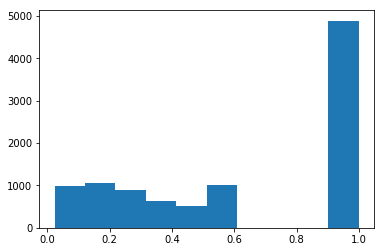

In [13]:
plt.hist(cred)

In [53]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

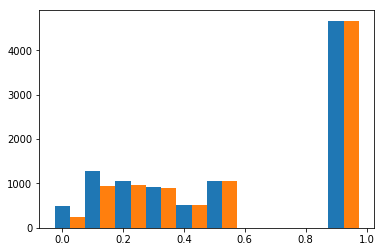

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [15]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.52764613, 0.83124478, 0.94539249, 0.98878343, 0.99498495,
              nan,        nan,        nan,        nan, 0.99922103])

In [45]:
dknn.A.mean()

0.17333333333333334

In [154]:
nn = dknn.get_neighbors(x_valid)

In [15]:
for (D, I) in nn:
    print(D[-1].mean())

0.72602546
0.6874378
0.7105881
0.94844836


## PGD Attack

In [17]:
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.numpy()

In [18]:
model = foolbox.models.PyTorchModel(net, bounds=(0, 1), num_classes=10)

In [ ]:
criterion = foolbox.criteria.Misclassification()
distance = foolbox.distances.Linfinity

attack = foolbox.attacks.RandomPGD(
    model, criterion=criterion, distance=distance)

def attack_wrap(x, y):
    return attack(x, y, binary_search=False, epsilon=0.3, 
                  stepsize=0.01, iterations=300, 
                  random_start=True, return_early=True)

x_adv = np.zeros_like(x_test_np)
for i, (x, y) in enumerate(zip(x_test_np, y_test_np)):
    x_adv[i] = attack_wrap(x, y)

In [ ]:
with torch.no_grad():
    x_adv = torch.tensor(x_adv).to(device)
    y_pred = net(x_adv).detach().cpu().numpy()
np.mean(np.argmax(y_pred, 1) == y_test)

In [29]:
from lib.pgd_attack import PGDAttack

attack = PGDAttack()
x_adv = attack(net, x_test.cuda(), y_test.to(device),
               targeted=False, epsilon=0.01, max_epsilon=0.3,
               max_iterations=300, num_restart=10, rand_start=True)

number of successful adv: 820/10000


In [30]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test).sum().item()

9180

In [31]:
y_pred = dknn.classify(x_adv.cpu())
(y_pred.argmax(1) == y_test.numpy()).sum()

NameError: name 'dknn' is not defined

(array([9.63e+03, 2.96e+02, 5.70e+01, 7.00e+00, 5.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 4.00e+00]),
 array([0.00383333, 0.10345   , 0.20306667, 0.30268333, 0.4023    ,
        0.50191667, 0.60153333, 0.70115   , 0.80076667, 0.90038333,
        1.        ]),
 <a list of 10 Patch objects>)

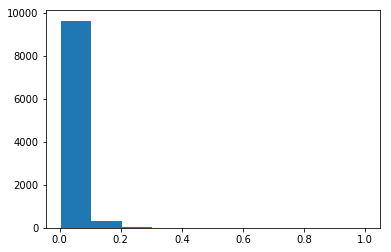

In [55]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [11]:
np.mean(y_pred == y_test)

0.9091

## DkNN Attack

In [55]:
# attack = DKNNAttack()

from lib.dknn_attack_l2 import DKNNL2Attack
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=10,
            max_iterations=500, learning_rate=1e-1,
            initial_const=1e-1, abort_early=True)
    return x_adv

num = 1000
x_adv = attack_batch(x_test[:num].cuda(), y_test[:num], 100)

    step: 0; loss: 14.109; l2dist: 0.000
    step: 50; loss: 10.948; l2dist: 1.190
    step: 100; loss: 9.823; l2dist: 1.287
    step: 150; loss: 9.276; l2dist: 1.311
    step: 200; loss: 9.182; l2dist: 1.309
    step: 250; loss: 9.152; l2dist: 1.307
    step: 300; loss: 9.139; l2dist: 1.306
    step: 350; loss: 9.132; l2dist: 1.306
    step: 400; loss: 9.128; l2dist: 1.306
    step: 450; loss: 9.125; l2dist: 1.306
tensor(25., device='cuda:0')
binary step: 0; number of successful adv: 25/100
    step: 0; loss: 117.042; l2dist: 0.000
    step: 50; loss: 62.943; l2dist: 2.664
    step: 100; loss: 53.316; l2dist: 2.150
    step: 150; loss: 52.207; l2dist: 1.985
    step: 200; loss: 51.862; l2dist: 1.933
    step: 250; loss: 51.742; l2dist: 1.913
    step: 300; loss: 51.684; l2dist: 1.904
    step: 350; loss: 51.645; l2dist: 1.897
    step: 400; loss: 51.629; l2dist: 1.894
    step: 450; loss: 51.622; l2dist: 1.893
tensor(71., device='cuda:0')
binary step: 1; number of successful adv: 81/1

    step: 150; loss: 119.403; l2dist: 1.939
    step: 200; loss: 118.960; l2dist: 1.876
    step: 250; loss: 118.673; l2dist: 1.835
    step: 300; loss: 118.474; l2dist: 1.805
    step: 350; loss: 118.343; l2dist: 1.785
    step: 400; loss: 118.234; l2dist: 1.767
    step: 450; loss: 118.167; l2dist: 1.756
tensor(69., device='cuda:0')
binary step: 2; number of successful adv: 87/100
    step: 0; loss: 1862.874; l2dist: 0.000
    step: 50; loss: 916.313; l2dist: 2.168
    step: 100; loss: 908.368; l2dist: 2.058
    step: 150; loss: 907.772; l2dist: 1.985
    step: 200; loss: 907.536; l2dist: 1.956
    step: 250; loss: 907.359; l2dist: 1.936
    step: 300; loss: 907.189; l2dist: 1.918
    step: 350; loss: 907.037; l2dist: 1.901
    step: 400; loss: 906.902; l2dist: 1.885
    step: 450; loss: 906.775; l2dist: 1.870
tensor(70., device='cuda:0')
binary step: 3; number of successful adv: 88/100
    step: 0; loss: 17338.039; l2dist: 0.000
    step: 50; loss: 8503.896; l2dist: 2.033
    step: 

    step: 50; loss: 55886.492; l2dist: 1.786
    step: 100; loss: 55009.500; l2dist: 1.727
    step: 150; loss: 55006.242; l2dist: 1.677
tensor(46., device='cuda:0')
binary step: 5; number of successful adv: 92/100
    step: 0; loss: 1169630.375; l2dist: 0.000
    step: 50; loss: 558626.812; l2dist: 1.774
    step: 100; loss: 549897.188; l2dist: 1.714
    step: 150; loss: 549869.562; l2dist: 1.671
tensor(41., device='cuda:0')
binary step: 6; number of successful adv: 92/100
    step: 0; loss: 11695959.000; l2dist: 0.000
    step: 50; loss: 5586028.500; l2dist: 1.772
    step: 100; loss: 5498772.500; l2dist: 1.714
    step: 150; loss: 5498501.000; l2dist: 1.671
tensor(43., device='cuda:0')
binary step: 7; number of successful adv: 92/100
    step: 0; loss: 116959248.000; l2dist: 0.000
    step: 50; loss: 55860044.000; l2dist: 1.771
    step: 100; loss: 54987528.000; l2dist: 1.717
    step: 150; loss: 54984816.000; l2dist: 1.670
tensor(43., device='cuda:0')
binary step: 8; number of succ

    step: 0; loss: 13.707; l2dist: 0.000
    step: 50; loss: 10.731; l2dist: 1.142
    step: 100; loss: 9.641; l2dist: 1.242
    step: 150; loss: 9.016; l2dist: 1.277
    step: 200; loss: 8.921; l2dist: 1.277
    step: 250; loss: 8.893; l2dist: 1.275
    step: 300; loss: 8.881; l2dist: 1.275
    step: 350; loss: 8.874; l2dist: 1.274
    step: 400; loss: 8.870; l2dist: 1.274
    step: 450; loss: 8.868; l2dist: 1.274
tensor(26., device='cuda:0')
binary step: 0; number of successful adv: 26/100
    step: 0; loss: 113.762; l2dist: 0.000
    step: 50; loss: 62.509; l2dist: 2.574
    step: 100; loss: 51.873; l2dist: 2.078
    step: 150; loss: 50.842; l2dist: 1.928
    step: 200; loss: 50.480; l2dist: 1.872
    step: 250; loss: 50.333; l2dist: 1.850
    step: 300; loss: 50.275; l2dist: 1.840
    step: 350; loss: 50.246; l2dist: 1.836
    step: 400; loss: 50.228; l2dist: 1.833
    step: 450; loss: 50.219; l2dist: 1.832
tensor(77., device='cuda:0')
binary step: 1; number of successful adv: 85/1

    step: 200; loss: 137.036; l2dist: 1.876
    step: 250; loss: 136.689; l2dist: 1.833
    step: 300; loss: 136.447; l2dist: 1.799
    step: 350; loss: 136.253; l2dist: 1.772
    step: 400; loss: 136.077; l2dist: 1.746
    step: 450; loss: 135.932; l2dist: 1.725
tensor(78., device='cuda:0')
binary step: 2; number of successful adv: 91/100
    step: 0; loss: 1411.227; l2dist: 0.000
    step: 50; loss: 662.034; l2dist: 2.111
    step: 100; loss: 653.267; l2dist: 1.962
    step: 150; loss: 652.532; l2dist: 1.879
    step: 200; loss: 652.208; l2dist: 1.839
    step: 250; loss: 651.990; l2dist: 1.814
    step: 300; loss: 651.786; l2dist: 1.790
    step: 350; loss: 651.632; l2dist: 1.770
    step: 400; loss: 651.506; l2dist: 1.755
    step: 450; loss: 651.406; l2dist: 1.743
tensor(70., device='cuda:0')
binary step: 3; number of successful adv: 91/100
    step: 0; loss: 13120.391; l2dist: 0.000
    step: 50; loss: 6135.010; l2dist: 1.969
    step: 100; loss: 6085.607; l2dist: 1.868
    step:

In [56]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:num].numpy()).sum() / len(y_pred)

0.105

(array([864.,  26.,  13.,  12.,   9.,  16.,   0.,   0.,   0.,  60.]),
 array([0.0365 , 0.13285, 0.2292 , 0.32555, 0.4219 , 0.51825, 0.6146 ,
        0.71095, 0.8073 , 0.90365, 1.     ]),
 <a list of 10 Patch objects>)

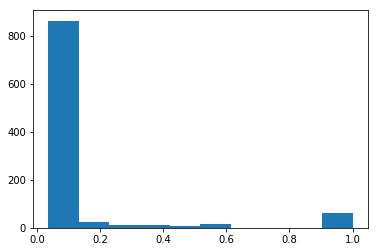

In [57]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

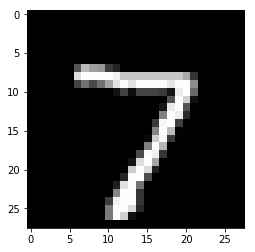

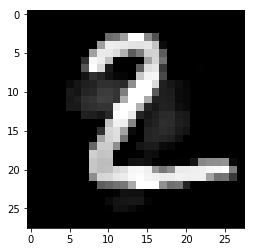

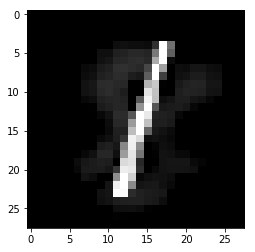

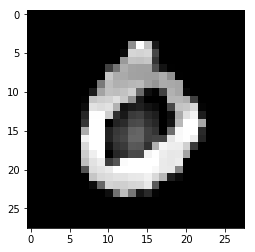

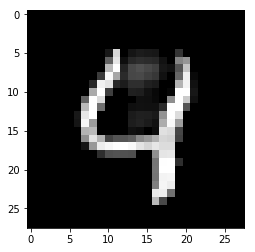

In [58]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

In [59]:
y_clean = dknn.classify(x_test[:num])
ind = (y_clean.argmax(1) == y_test[:num].numpy()) & (y_pred.argmax(1) != y_test[:num].numpy())
np.mean(np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:num][ind])**2, (1, 2, 3))))

1.6346755

In [60]:
np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:num][ind])**2, (1, 2, 3)))

array([1.7690771 , 1.5727358 , 2.7503514 , 1.2389098 , 1.6135488 ,
       1.6507565 , 1.6114699 , 2.6745708 , 1.6988411 , 1.1849897 ,
       1.7280196 , 1.073701  , 1.117185  , 3.6193776 , 0.20475903,
       1.5696911 , 1.6756727 , 1.5497293 , 1.531895  , 1.5029132 ,
       0.83050066, 3.8512247 , 1.3603473 , 3.219409  , 1.1694777 ,
       1.1214588 , 1.0054519 , 2.2142687 , 1.3744861 , 0.579396  ,
       1.5447656 , 1.6869639 , 1.4680444 , 0.34286806, 1.617254  ,
       1.2845362 , 1.202461  , 0.96131426, 1.6332853 , 1.7632225 ,
       1.8584356 , 1.392422  , 1.4776517 , 0.379419  , 1.6418229 ,
       2.1015382 , 2.7902954 , 1.4630202 , 1.5281005 , 1.3712598 ,
       2.9001687 , 0.70672876, 0.14354603, 1.7249051 , 0.65658015,
       0.16869728, 1.1320397 , 2.081553  , 2.0443232 , 4.4420156 ,
       1.3115183 , 1.314355  , 1.9395772 , 3.973562  , 0.6264785 ,
       1.695305  , 3.785954  , 1.2417407 , 0.72902596, 3.0008333 ,
       2.653672  , 2.2764254 , 1.5827845 , 2.8872643 , 0.50104

In [ ]:
# ours: [2.1830862, 4.239626, 2.6917257, 3.8731990, 1.4814271, 2.63134,
#        2.0538194, 1.270368, 2.9351923, 2.4314828]
# bd2:  [2.9166877, 2.957195, 2.9477980, 2.8653080, 1.2530060, 2.33518, 
#        1.6536615, 1.168170, 1.6185884, 2.3803349]

## CW L2 Attack

without DkNN

In [20]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=10, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1e1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:10000].cuda(), y_test[:10000].cuda(), 100)

    step: 0; loss: 121.171; l2dist: 0.000
    step: 50; loss: 14.259; l2dist: 3.370
    step: 100; loss: 5.832; l2dist: 2.329
    step: 150; loss: 3.887; l2dist: 1.881
    step: 200; loss: 3.105; l2dist: 1.666
    step: 250; loss: 2.774; l2dist: 1.574
    step: 300; loss: 2.581; l2dist: 1.513
    step: 350; loss: 2.525; l2dist: 1.488
    step: 400; loss: 2.486; l2dist: 1.473
    step: 450; loss: 2.449; l2dist: 1.461
binary step: 0; number of successful adv: 99/100
    step: 0; loss: 75.129; l2dist: 0.000
    step: 50; loss: 10.528; l2dist: 2.859
    step: 100; loss: 4.196; l2dist: 1.949
    step: 150; loss: 3.019; l2dist: 1.639
    step: 200; loss: 2.641; l2dist: 1.526
    step: 250; loss: 2.478; l2dist: 1.469
    step: 300; loss: 2.393; l2dist: 1.444
    step: 350; loss: 2.319; l2dist: 1.425
    step: 400; loss: 2.340; l2dist: 1.432
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 43.686; l2dist: 0.000
    step: 50; loss: 8.584; l2dist: 2.540
    step: 100; loss: 3

    step: 50; loss: 7.134; l2dist: 2.149
    step: 100; loss: 3.299; l2dist: 1.621
    step: 150; loss: 2.539; l2dist: 1.448
    step: 200; loss: 2.314; l2dist: 1.398
    step: 250; loss: 2.240; l2dist: 1.374
    step: 300; loss: 2.193; l2dist: 1.367
    step: 350; loss: 2.179; l2dist: 1.357
    step: 400; loss: 2.167; l2dist: 1.357
    step: 450; loss: 2.161; l2dist: 1.359
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 26.044; l2dist: 0.000
    step: 50; loss: 7.187; l2dist: 2.160
    step: 100; loss: 3.313; l2dist: 1.630
    step: 150; loss: 2.546; l2dist: 1.454
    step: 200; loss: 2.330; l2dist: 1.401
    step: 250; loss: 2.244; l2dist: 1.386
    step: 300; loss: 2.217; l2dist: 1.376
    step: 350; loss: 2.177; l2dist: 1.369
    step: 400; loss: 2.167; l2dist: 1.370
    step: 450; loss: 2.162; l2dist: 1.366
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 115.501; l2dist: 0.000
    step: 50; loss: 13.032; l2dist: 3.298
    step: 100; loss: 

    step: 50; loss: 5.832; l2dist: 1.872
    step: 100; loss: 2.763; l2dist: 1.472
    step: 150; loss: 2.047; l2dist: 1.311
    step: 200; loss: 1.904; l2dist: 1.269
    step: 250; loss: 1.822; l2dist: 1.253
    step: 300; loss: 1.793; l2dist: 1.241
    step: 350; loss: 1.778; l2dist: 1.242
    step: 400; loss: 1.769; l2dist: 1.239
    step: 450; loss: 1.767; l2dist: 1.236
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 17.685; l2dist: 0.000
    step: 50; loss: 5.802; l2dist: 1.867
    step: 100; loss: 2.769; l2dist: 1.466
    step: 150; loss: 2.049; l2dist: 1.309
    step: 200; loss: 1.898; l2dist: 1.274
    step: 250; loss: 1.836; l2dist: 1.255
    step: 300; loss: 1.810; l2dist: 1.247
    step: 350; loss: 1.785; l2dist: 1.244
    step: 400; loss: 1.773; l2dist: 1.241
    step: 450; loss: 1.769; l2dist: 1.240
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 17.334; l2dist: 0.000
    step: 50; loss: 5.791; l2dist: 1.857
    step: 100; loss: 2.

    step: 100; loss: 3.503; l2dist: 1.682
    step: 150; loss: 2.619; l2dist: 1.470
    step: 200; loss: 2.359; l2dist: 1.412
    step: 250; loss: 2.291; l2dist: 1.391
    step: 300; loss: 2.241; l2dist: 1.381
    step: 350; loss: 2.226; l2dist: 1.375
    step: 400; loss: 2.217; l2dist: 1.368
    step: 450; loss: 2.213; l2dist: 1.367
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 28.234; l2dist: 0.000
    step: 50; loss: 6.495; l2dist: 2.071
    step: 100; loss: 3.385; l2dist: 1.609
    step: 150; loss: 2.542; l2dist: 1.427
    step: 200; loss: 2.343; l2dist: 1.378
    step: 250; loss: 2.272; l2dist: 1.358
    step: 300; loss: 2.212; l2dist: 1.349
    step: 350; loss: 2.195; l2dist: 1.346
    step: 400; loss: 2.182; l2dist: 1.337
    step: 450; loss: 2.171; l2dist: 1.338
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 25.604; l2dist: 0.000
    step: 50; loss: 6.434; l2dist: 2.043
    step: 100; loss: 3.338; l2dist: 1.593
    step: 150; loss: 2

    step: 450; loss: 2.246; l2dist: 1.400
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 54.060; l2dist: 0.000
    step: 50; loss: 9.625; l2dist: 2.661
    step: 100; loss: 3.702; l2dist: 1.804
    step: 150; loss: 2.718; l2dist: 1.538
    step: 200; loss: 2.445; l2dist: 1.451
    step: 250; loss: 2.288; l2dist: 1.414
    step: 300; loss: 2.241; l2dist: 1.393
    step: 350; loss: 2.171; l2dist: 1.369
    step: 400; loss: 2.144; l2dist: 1.366
    step: 450; loss: 2.150; l2dist: 1.370
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 31.751; l2dist: 0.000
    step: 50; loss: 8.041; l2dist: 2.340
    step: 100; loss: 3.309; l2dist: 1.683
    step: 150; loss: 2.514; l2dist: 1.462
    step: 200; loss: 2.294; l2dist: 1.411
    step: 250; loss: 2.195; l2dist: 1.381
    step: 300; loss: 2.163; l2dist: 1.370
    step: 350; loss: 2.133; l2dist: 1.355
    step: 400; loss: 2.100; l2dist: 1.355
    step: 450; loss: 2.088; l2dist: 1.343
binary step: 3; number

    step: 400; loss: 2.225; l2dist: 1.389
    step: 450; loss: 2.223; l2dist: 1.393
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 113.710; l2dist: 0.000
    step: 50; loss: 12.560; l2dist: 3.247
    step: 100; loss: 5.202; l2dist: 2.162
    step: 150; loss: 3.443; l2dist: 1.734
    step: 200; loss: 2.756; l2dist: 1.530
    step: 250; loss: 2.489; l2dist: 1.443
    step: 300; loss: 2.369; l2dist: 1.401
    step: 350; loss: 2.356; l2dist: 1.390
    step: 400; loss: 2.278; l2dist: 1.365
    step: 450; loss: 2.304; l2dist: 1.372
binary step: 0; number of successful adv: 98/100
    step: 0; loss: 78.766; l2dist: 0.000
    step: 50; loss: 10.431; l2dist: 2.883
    step: 100; loss: 4.025; l2dist: 1.859
    step: 150; loss: 2.864; l2dist: 1.544
    step: 200; loss: 2.471; l2dist: 1.420
    step: 250; loss: 2.291; l2dist: 1.368
    step: 300; loss: 2.241; l2dist: 1.348
    step: 350; loss: 2.178; l2dist: 1.336
    step: 400; loss: 2.194; l2dist: 1.332
binary step: 1; numb

binary step: 7; number of successful adv: 100/100
    step: 0; loss: 17.494; l2dist: 0.000
    step: 50; loss: 5.613; l2dist: 1.858
    step: 100; loss: 2.918; l2dist: 1.477
    step: 150; loss: 2.163; l2dist: 1.311
    step: 200; loss: 1.980; l2dist: 1.270
    step: 250; loss: 1.912; l2dist: 1.256
    step: 300; loss: 1.876; l2dist: 1.241
    step: 350; loss: 1.868; l2dist: 1.239
    step: 400; loss: 1.852; l2dist: 1.233
    step: 450; loss: 1.848; l2dist: 1.228
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 17.623; l2dist: 0.000
    step: 50; loss: 5.644; l2dist: 1.869
    step: 100; loss: 2.921; l2dist: 1.484
    step: 150; loss: 2.163; l2dist: 1.321
    step: 200; loss: 1.992; l2dist: 1.274
    step: 250; loss: 1.915; l2dist: 1.252
    step: 300; loss: 1.893; l2dist: 1.247
    step: 350; loss: 1.867; l2dist: 1.242
    step: 400; loss: 1.850; l2dist: 1.240
    step: 450; loss: 1.846; l2dist: 1.235
binary step: 9; number of successful adv: 100/100
    step: 0; l

    step: 450; loss: 1.853; l2dist: 1.235
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 12.691; l2dist: 0.000
    step: 50; loss: 5.302; l2dist: 1.766
    step: 100; loss: 2.844; l2dist: 1.452
    step: 150; loss: 2.118; l2dist: 1.290
    step: 200; loss: 1.964; l2dist: 1.254
    step: 250; loss: 1.904; l2dist: 1.242
    step: 300; loss: 1.876; l2dist: 1.228
    step: 350; loss: 1.868; l2dist: 1.233
    step: 400; loss: 1.857; l2dist: 1.227
    step: 450; loss: 1.861; l2dist: 1.224
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 12.577; l2dist: 0.000
    step: 50; loss: 5.285; l2dist: 1.754
    step: 100; loss: 2.857; l2dist: 1.452
    step: 150; loss: 2.125; l2dist: 1.289
    step: 200; loss: 1.965; l2dist: 1.250
    step: 250; loss: 1.919; l2dist: 1.232
    step: 300; loss: 1.881; l2dist: 1.225
    step: 350; loss: 1.875; l2dist: 1.228
    step: 400; loss: 1.857; l2dist: 1.228
    step: 450; loss: 1.863; l2dist: 1.220
binary step: 7; number

    step: 250; loss: 2.105; l2dist: 1.353
    step: 300; loss: 2.075; l2dist: 1.335
    step: 350; loss: 2.046; l2dist: 1.335
    step: 400; loss: 2.039; l2dist: 1.327
    step: 450; loss: 2.023; l2dist: 1.322
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 18.349; l2dist: 0.000
    step: 50; loss: 6.321; l2dist: 2.015
    step: 100; loss: 3.054; l2dist: 1.603
    step: 150; loss: 2.299; l2dist: 1.404
    step: 200; loss: 2.117; l2dist: 1.348
    step: 250; loss: 2.058; l2dist: 1.320
    step: 300; loss: 2.025; l2dist: 1.311
    step: 350; loss: 2.004; l2dist: 1.305
    step: 400; loss: 1.999; l2dist: 1.310
    step: 450; loss: 1.999; l2dist: 1.298
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 17.307; l2dist: 0.000
    step: 50; loss: 6.178; l2dist: 1.936
    step: 100; loss: 3.011; l2dist: 1.525
    step: 150; loss: 2.289; l2dist: 1.358
    step: 200; loss: 2.101; l2dist: 1.315
    step: 250; loss: 2.041; l2dist: 1.297
    step: 300; loss: 2

    step: 50; loss: 11.448; l2dist: 3.046
    step: 100; loss: 4.760; l2dist: 2.047
    step: 150; loss: 3.297; l2dist: 1.683
    step: 200; loss: 2.727; l2dist: 1.531
    step: 250; loss: 2.474; l2dist: 1.457
    step: 300; loss: 2.329; l2dist: 1.421
    step: 350; loss: 2.279; l2dist: 1.409
    step: 400; loss: 2.207; l2dist: 1.383
    step: 450; loss: 2.172; l2dist: 1.376
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 60.307; l2dist: 0.000
    step: 50; loss: 8.909; l2dist: 2.616
    step: 100; loss: 3.730; l2dist: 1.803
    step: 150; loss: 2.728; l2dist: 1.536
    step: 200; loss: 2.410; l2dist: 1.452
    step: 250; loss: 2.257; l2dist: 1.398
    step: 300; loss: 2.158; l2dist: 1.369
    step: 350; loss: 2.115; l2dist: 1.359
    step: 400; loss: 2.102; l2dist: 1.361
    step: 450; loss: 2.101; l2dist: 1.357
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 37.309; l2dist: 0.000
    step: 50; loss: 7.398; l2dist: 2.319
    step: 100; loss: 3

    step: 50; loss: 6.174; l2dist: 2.060
    step: 100; loss: 3.069; l2dist: 1.554
    step: 150; loss: 2.239; l2dist: 1.358
    step: 200; loss: 2.052; l2dist: 1.305
    step: 250; loss: 1.961; l2dist: 1.289
    step: 300; loss: 1.937; l2dist: 1.277
    step: 350; loss: 1.906; l2dist: 1.270
    step: 400; loss: 1.906; l2dist: 1.270
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 117.452; l2dist: 0.000
    step: 50; loss: 12.977; l2dist: 3.298
    step: 100; loss: 5.412; l2dist: 2.241
    step: 150; loss: 3.495; l2dist: 1.776
    step: 200; loss: 2.787; l2dist: 1.568
    step: 250; loss: 2.454; l2dist: 1.468
    step: 300; loss: 2.291; l2dist: 1.413
    step: 350; loss: 2.247; l2dist: 1.384
    step: 400; loss: 2.218; l2dist: 1.372
    step: 450; loss: 2.183; l2dist: 1.363
binary step: 0; number of successful adv: 100/100
    step: 0; loss: 58.726; l2dist: 0.000
    step: 50; loss: 9.684; l2dist: 2.765
    step: 100; loss: 3.628; l2dist: 1.812
    step: 150; loss: 

    step: 400; loss: 1.776; l2dist: 1.204
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 17.796; l2dist: 0.000
    step: 50; loss: 5.441; l2dist: 1.869
    step: 100; loss: 2.751; l2dist: 1.454
    step: 150; loss: 2.059; l2dist: 1.280
    step: 200; loss: 1.889; l2dist: 1.230
    step: 250; loss: 1.825; l2dist: 1.220
    step: 300; loss: 1.792; l2dist: 1.204
    step: 350; loss: 1.763; l2dist: 1.206
    step: 400; loss: 1.755; l2dist: 1.203
    step: 450; loss: 1.741; l2dist: 1.199
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 17.366; l2dist: 0.000
    step: 50; loss: 5.421; l2dist: 1.863
    step: 100; loss: 2.754; l2dist: 1.456
    step: 150; loss: 2.064; l2dist: 1.275
    step: 200; loss: 1.883; l2dist: 1.237
    step: 250; loss: 1.824; l2dist: 1.221
    step: 300; loss: 1.783; l2dist: 1.212
    step: 350; loss: 1.765; l2dist: 1.205
    step: 400; loss: 1.752; l2dist: 1.202
    step: 450; loss: 1.754; l2dist: 1.204
binary step: 8; number

    step: 400; loss: 2.051; l2dist: 1.316
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 22.509; l2dist: 0.000
    step: 50; loss: 5.817; l2dist: 1.902
    step: 100; loss: 3.051; l2dist: 1.507
    step: 150; loss: 2.329; l2dist: 1.349
    step: 200; loss: 2.142; l2dist: 1.310
    step: 250; loss: 2.066; l2dist: 1.285
    step: 300; loss: 2.033; l2dist: 1.280
    step: 350; loss: 2.006; l2dist: 1.282
    step: 400; loss: 1.993; l2dist: 1.276
    step: 450; loss: 1.996; l2dist: 1.270
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 22.142; l2dist: 0.000
    step: 50; loss: 5.892; l2dist: 1.898
    step: 100; loss: 3.102; l2dist: 1.506
    step: 150; loss: 2.404; l2dist: 1.366
    step: 200; loss: 2.188; l2dist: 1.312
    step: 250; loss: 2.105; l2dist: 1.301
    step: 300; loss: 2.063; l2dist: 1.293
    step: 350; loss: 2.050; l2dist: 1.290
    step: 400; loss: 2.034; l2dist: 1.284
    step: 450; loss: 2.025; l2dist: 1.285
binary step: 6; number

    step: 350; loss: 2.218; l2dist: 1.376
    step: 400; loss: 2.191; l2dist: 1.364
    step: 450; loss: 2.161; l2dist: 1.363
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 39.538; l2dist: 0.000
    step: 50; loss: 7.441; l2dist: 2.335
    step: 100; loss: 3.401; l2dist: 1.707
    step: 150; loss: 2.565; l2dist: 1.483
    step: 200; loss: 2.295; l2dist: 1.403
    step: 250; loss: 2.205; l2dist: 1.375
    step: 300; loss: 2.159; l2dist: 1.362
    step: 350; loss: 2.146; l2dist: 1.354
    step: 400; loss: 2.124; l2dist: 1.349
    step: 450; loss: 2.111; l2dist: 1.342
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 29.191; l2dist: 0.000
    step: 50; loss: 6.868; l2dist: 2.198
    step: 100; loss: 3.244; l2dist: 1.639
    step: 150; loss: 2.452; l2dist: 1.433
    step: 200; loss: 2.262; l2dist: 1.381
    step: 250; loss: 2.183; l2dist: 1.357
    step: 300; loss: 2.136; l2dist: 1.347
    step: 350; loss: 2.125; l2dist: 1.335
    step: 400; loss: 2

    step: 150; loss: 3.752; l2dist: 1.843
    step: 200; loss: 3.044; l2dist: 1.650
    step: 250; loss: 2.721; l2dist: 1.550
    step: 300; loss: 2.530; l2dist: 1.493
    step: 350; loss: 2.466; l2dist: 1.476
    step: 400; loss: 2.449; l2dist: 1.472
    step: 450; loss: 2.399; l2dist: 1.452
binary step: 0; number of successful adv: 92/100
    step: 0; loss: 165.769; l2dist: 0.000
    step: 50; loss: 13.428; l2dist: 3.426
    step: 100; loss: 6.690; l2dist: 2.406
    step: 150; loss: 4.475; l2dist: 1.942
    step: 200; loss: 3.485; l2dist: 1.716
    step: 250; loss: 2.960; l2dist: 1.595
    step: 300; loss: 2.730; l2dist: 1.528
    step: 350; loss: 2.574; l2dist: 1.498
    step: 400; loss: 2.511; l2dist: 1.478
    step: 450; loss: 2.430; l2dist: 1.453
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 90.306; l2dist: 0.000
    step: 50; loss: 10.282; l2dist: 2.941
    step: 100; loss: 4.683; l2dist: 2.006
    step: 150; loss: 3.237; l2dist: 1.667
    step: 200; loss:

    step: 50; loss: 5.519; l2dist: 1.811
    step: 100; loss: 3.256; l2dist: 1.547
    step: 150; loss: 2.422; l2dist: 1.394
    step: 200; loss: 2.214; l2dist: 1.352
    step: 250; loss: 2.135; l2dist: 1.338
    step: 300; loss: 2.109; l2dist: 1.324
    step: 350; loss: 2.079; l2dist: 1.323
    step: 400; loss: 2.074; l2dist: 1.323
    step: 450; loss: 2.064; l2dist: 1.319
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 16.171; l2dist: 0.000
    step: 50; loss: 5.581; l2dist: 1.830
    step: 100; loss: 3.260; l2dist: 1.556
    step: 150; loss: 2.426; l2dist: 1.401
    step: 200; loss: 2.217; l2dist: 1.357
    step: 250; loss: 2.139; l2dist: 1.346
    step: 300; loss: 2.111; l2dist: 1.331
    step: 350; loss: 2.086; l2dist: 1.335
    step: 400; loss: 2.080; l2dist: 1.324
    step: 450; loss: 2.071; l2dist: 1.332
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 117.455; l2dist: 0.000
    step: 50; loss: 13.962; l2dist: 3.367
    step: 100; loss: 

    step: 100; loss: 2.772; l2dist: 1.428
    step: 150; loss: 2.069; l2dist: 1.281
    step: 200; loss: 1.897; l2dist: 1.238
    step: 250; loss: 1.849; l2dist: 1.224
    step: 300; loss: 1.799; l2dist: 1.212
    step: 350; loss: 1.786; l2dist: 1.213
    step: 400; loss: 1.772; l2dist: 1.209
    step: 450; loss: 1.776; l2dist: 1.208
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 18.735; l2dist: 0.000
    step: 50; loss: 5.251; l2dist: 1.797
    step: 100; loss: 2.784; l2dist: 1.432
    step: 150; loss: 2.080; l2dist: 1.288
    step: 200; loss: 1.905; l2dist: 1.247
    step: 250; loss: 1.859; l2dist: 1.232
    step: 300; loss: 1.825; l2dist: 1.230
    step: 350; loss: 1.795; l2dist: 1.215
    step: 400; loss: 1.797; l2dist: 1.221
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 18.383; l2dist: 0.000
    step: 50; loss: 5.221; l2dist: 1.790
    step: 100; loss: 2.779; l2dist: 1.430
    step: 150; loss: 2.080; l2dist: 1.287
    step: 200; loss: 1

binary step: 3; number of successful adv: 100/100
    step: 0; loss: 23.656; l2dist: 0.000
    step: 50; loss: 7.630; l2dist: 2.216
    step: 100; loss: 3.577; l2dist: 1.715
    step: 150; loss: 2.696; l2dist: 1.516
    step: 200; loss: 2.476; l2dist: 1.449
    step: 250; loss: 2.400; l2dist: 1.428
    step: 300; loss: 2.355; l2dist: 1.415
    step: 350; loss: 2.321; l2dist: 1.411
    step: 400; loss: 2.294; l2dist: 1.407
    step: 450; loss: 2.281; l2dist: 1.403
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 21.096; l2dist: 0.000
    step: 50; loss: 7.393; l2dist: 2.162
    step: 100; loss: 3.517; l2dist: 1.673
    step: 150; loss: 2.670; l2dist: 1.482
    step: 200; loss: 2.457; l2dist: 1.431
    step: 250; loss: 2.381; l2dist: 1.412
    step: 300; loss: 2.327; l2dist: 1.397
    step: 350; loss: 2.307; l2dist: 1.395
    step: 400; loss: 2.296; l2dist: 1.391
    step: 450; loss: 2.275; l2dist: 1.387
binary step: 5; number of successful adv: 100/100
    step: 0; l

    step: 400; loss: 2.124; l2dist: 1.349
    step: 450; loss: 2.084; l2dist: 1.341
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 45.535; l2dist: 0.000
    step: 50; loss: 7.565; l2dist: 2.391
    step: 100; loss: 3.301; l2dist: 1.689
    step: 150; loss: 2.475; l2dist: 1.454
    step: 200; loss: 2.230; l2dist: 1.387
    step: 250; loss: 2.112; l2dist: 1.357
    step: 300; loss: 2.079; l2dist: 1.333
    step: 350; loss: 2.030; l2dist: 1.324
    step: 400; loss: 2.011; l2dist: 1.321
    step: 450; loss: 1.995; l2dist: 1.317
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 26.521; l2dist: 0.000
    step: 50; loss: 6.198; l2dist: 2.054
    step: 100; loss: 3.072; l2dist: 1.616
    step: 150; loss: 2.317; l2dist: 1.409
    step: 200; loss: 2.127; l2dist: 1.353
    step: 250; loss: 2.055; l2dist: 1.325
    step: 300; loss: 2.017; l2dist: 1.325
    step: 350; loss: 1.974; l2dist: 1.306
    step: 400; loss: 1.968; l2dist: 1.297
    step: 450; loss: 1

    step: 300; loss: 1.993; l2dist: 1.284
    step: 350; loss: 1.975; l2dist: 1.285
    step: 400; loss: 1.964; l2dist: 1.281
    step: 450; loss: 1.962; l2dist: 1.276
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 123.943; l2dist: 0.000
    step: 50; loss: 13.248; l2dist: 3.346
    step: 100; loss: 5.697; l2dist: 2.289
    step: 150; loss: 3.773; l2dist: 1.846
    step: 200; loss: 2.979; l2dist: 1.631
    step: 250; loss: 2.624; l2dist: 1.527
    step: 300; loss: 2.472; l2dist: 1.479
    step: 350; loss: 2.406; l2dist: 1.447
    step: 400; loss: 2.346; l2dist: 1.443
    step: 450; loss: 2.335; l2dist: 1.419
binary step: 0; number of successful adv: 99/100
    step: 0; loss: 72.482; l2dist: 0.000
    step: 50; loss: 10.147; l2dist: 2.863
    step: 100; loss: 4.136; l2dist: 1.919
    step: 150; loss: 2.910; l2dist: 1.604
    step: 200; loss: 2.500; l2dist: 1.478
    step: 250; loss: 2.335; l2dist: 1.425
    step: 300; loss: 2.246; l2dist: 1.406
    step: 350; loss:

    step: 100; loss: 3.015; l2dist: 1.509
    step: 150; loss: 2.271; l2dist: 1.336
    step: 200; loss: 2.081; l2dist: 1.289
    step: 250; loss: 2.014; l2dist: 1.274
    step: 300; loss: 1.985; l2dist: 1.266
    step: 350; loss: 1.960; l2dist: 1.264
    step: 400; loss: 1.949; l2dist: 1.257
    step: 450; loss: 1.948; l2dist: 1.258
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 18.571; l2dist: 0.000
    step: 50; loss: 6.010; l2dist: 1.938
    step: 100; loss: 3.016; l2dist: 1.511
    step: 150; loss: 2.271; l2dist: 1.335
    step: 200; loss: 2.081; l2dist: 1.291
    step: 250; loss: 2.008; l2dist: 1.274
    step: 300; loss: 1.972; l2dist: 1.270
    step: 350; loss: 1.957; l2dist: 1.260
    step: 400; loss: 1.953; l2dist: 1.260
    step: 450; loss: 1.946; l2dist: 1.262
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 18.735; l2dist: 0.000
    step: 50; loss: 6.050; l2dist: 1.952
    step: 100; loss: 3.040; l2dist: 1.520
    step: 150; loss: 2

    step: 400; loss: 1.828; l2dist: 1.232
    step: 450; loss: 1.823; l2dist: 1.236
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 20.722; l2dist: 0.000
    step: 50; loss: 5.336; l2dist: 1.895
    step: 100; loss: 2.792; l2dist: 1.460
    step: 150; loss: 2.097; l2dist: 1.295
    step: 200; loss: 1.948; l2dist: 1.251
    step: 250; loss: 1.873; l2dist: 1.230
    step: 300; loss: 1.835; l2dist: 1.228
    step: 350; loss: 1.828; l2dist: 1.218
    step: 400; loss: 1.808; l2dist: 1.219
    step: 450; loss: 1.803; l2dist: 1.214
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 19.958; l2dist: 0.000
    step: 50; loss: 5.302; l2dist: 1.880
    step: 100; loss: 2.764; l2dist: 1.444
    step: 150; loss: 2.078; l2dist: 1.274
    step: 200; loss: 1.922; l2dist: 1.232
    step: 250; loss: 1.861; l2dist: 1.212
    step: 300; loss: 1.824; l2dist: 1.212
    step: 350; loss: 1.816; l2dist: 1.207
    step: 400; loss: 1.803; l2dist: 1.203
    step: 450; loss: 1

    step: 250; loss: 2.330; l2dist: 1.431
    step: 300; loss: 2.221; l2dist: 1.398
    step: 350; loss: 2.131; l2dist: 1.368
    step: 400; loss: 2.127; l2dist: 1.376
    step: 450; loss: 2.102; l2dist: 1.368
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 47.329; l2dist: 0.000
    step: 50; loss: 7.693; l2dist: 2.356
    step: 100; loss: 3.500; l2dist: 1.737
    step: 150; loss: 2.508; l2dist: 1.480
    step: 200; loss: 2.218; l2dist: 1.396
    step: 250; loss: 2.127; l2dist: 1.370
    step: 300; loss: 2.062; l2dist: 1.350
    step: 350; loss: 2.036; l2dist: 1.336
    step: 400; loss: 2.069; l2dist: 1.347
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 33.059; l2dist: 0.000
    step: 50; loss: 6.849; l2dist: 2.167
    step: 100; loss: 3.257; l2dist: 1.648
    step: 150; loss: 2.363; l2dist: 1.426
    step: 200; loss: 2.153; l2dist: 1.369
    step: 250; loss: 2.073; l2dist: 1.342
    step: 300; loss: 2.027; l2dist: 1.327
    step: 350; loss: 2

    step: 300; loss: 2.285; l2dist: 1.417
    step: 350; loss: 2.225; l2dist: 1.390
    step: 400; loss: 2.202; l2dist: 1.387
    step: 450; loss: 2.186; l2dist: 1.384
binary step: 0; number of successful adv: 98/100
    step: 0; loss: 79.316; l2dist: 0.000
    step: 50; loss: 9.887; l2dist: 2.815
    step: 100; loss: 4.072; l2dist: 1.890
    step: 150; loss: 2.861; l2dist: 1.563
    step: 200; loss: 2.448; l2dist: 1.441
    step: 250; loss: 2.284; l2dist: 1.387
    step: 300; loss: 2.223; l2dist: 1.368
    step: 350; loss: 2.135; l2dist: 1.351
    step: 400; loss: 2.105; l2dist: 1.348
    step: 450; loss: 2.101; l2dist: 1.343
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 45.344; l2dist: 0.000
    step: 50; loss: 8.046; l2dist: 2.435
    step: 100; loss: 3.321; l2dist: 1.696
    step: 150; loss: 2.476; l2dist: 1.459
    step: 200; loss: 2.233; l2dist: 1.386
    step: 250; loss: 2.142; l2dist: 1.351
    step: 300; loss: 2.052; l2dist: 1.326
    step: 350; loss: 2.

    step: 150; loss: 2.316; l2dist: 1.347
    step: 200; loss: 2.136; l2dist: 1.306
    step: 250; loss: 2.082; l2dist: 1.300
    step: 300; loss: 2.040; l2dist: 1.285
    step: 350; loss: 2.028; l2dist: 1.285
    step: 400; loss: 2.013; l2dist: 1.282
    step: 450; loss: 2.008; l2dist: 1.278
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 18.792; l2dist: 0.000
    step: 50; loss: 6.168; l2dist: 1.934
    step: 100; loss: 3.120; l2dist: 1.522
    step: 150; loss: 2.328; l2dist: 1.356
    step: 200; loss: 2.163; l2dist: 1.316
    step: 250; loss: 2.093; l2dist: 1.297
    step: 300; loss: 2.044; l2dist: 1.291
    step: 350; loss: 2.025; l2dist: 1.288
    step: 400; loss: 2.017; l2dist: 1.286
    step: 450; loss: 2.013; l2dist: 1.280
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 110.726; l2dist: 0.000
    step: 50; loss: 10.885; l2dist: 3.137
    step: 100; loss: 4.882; l2dist: 2.108
    step: 150; loss: 3.176; l2dist: 1.680
    step: 200; loss:

    step: 50; loss: 6.436; l2dist: 1.942
    step: 100; loss: 3.238; l2dist: 1.543
    step: 150; loss: 2.444; l2dist: 1.387
    step: 200; loss: 2.236; l2dist: 1.335
    step: 250; loss: 2.143; l2dist: 1.317
    step: 300; loss: 2.095; l2dist: 1.307
    step: 350; loss: 2.081; l2dist: 1.300
    step: 400; loss: 2.047; l2dist: 1.296
    step: 450; loss: 2.050; l2dist: 1.296
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 25.952; l2dist: 0.000
    step: 50; loss: 6.391; l2dist: 1.926
    step: 100; loss: 3.228; l2dist: 1.543
    step: 150; loss: 2.435; l2dist: 1.383
    step: 200; loss: 2.223; l2dist: 1.333
    step: 250; loss: 2.139; l2dist: 1.314
    step: 300; loss: 2.092; l2dist: 1.303
    step: 350; loss: 2.063; l2dist: 1.299
    step: 400; loss: 2.048; l2dist: 1.292
    step: 450; loss: 2.053; l2dist: 1.297
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 25.520; l2dist: 0.000
    step: 50; loss: 6.351; l2dist: 1.915
    step: 100; loss: 3.

    step: 350; loss: 2.318; l2dist: 1.436
    step: 400; loss: 2.282; l2dist: 1.415
    step: 450; loss: 2.254; l2dist: 1.412
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 38.662; l2dist: 0.000
    step: 50; loss: 7.392; l2dist: 2.284
    step: 100; loss: 3.659; l2dist: 1.725
    step: 150; loss: 2.752; l2dist: 1.523
    step: 200; loss: 2.465; l2dist: 1.451
    step: 250; loss: 2.380; l2dist: 1.427
    step: 300; loss: 2.296; l2dist: 1.408
    step: 350; loss: 2.253; l2dist: 1.398
    step: 400; loss: 2.248; l2dist: 1.392
    step: 450; loss: 2.218; l2dist: 1.391
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 33.982; l2dist: 0.000
    step: 50; loss: 6.967; l2dist: 2.187
    step: 100; loss: 3.561; l2dist: 1.665
    step: 150; loss: 2.699; l2dist: 1.466
    step: 200; loss: 2.436; l2dist: 1.415
    step: 250; loss: 2.345; l2dist: 1.388
    step: 300; loss: 2.306; l2dist: 1.388
    step: 350; loss: 2.357; l2dist: 1.389
binary step: 5; number

    step: 400; loss: 2.221; l2dist: 1.372
    step: 450; loss: 2.175; l2dist: 1.360
binary step: 1; number of successful adv: 99/100
    step: 0; loss: 215.070; l2dist: 0.000
    step: 50; loss: 17.873; l2dist: 3.688
    step: 100; loss: 8.082; l2dist: 2.658
    step: 150; loss: 5.299; l2dist: 2.127
    step: 200; loss: 3.905; l2dist: 1.814
    step: 250; loss: 3.144; l2dist: 1.632
    step: 300; loss: 2.728; l2dist: 1.518
    step: 350; loss: 2.583; l2dist: 1.474
    step: 400; loss: 2.423; l2dist: 1.438
    step: 450; loss: 2.356; l2dist: 1.418
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 119.180; l2dist: 0.000
    step: 50; loss: 12.968; l2dist: 3.087
    step: 100; loss: 5.390; l2dist: 2.147
    step: 150; loss: 3.513; l2dist: 1.716
    step: 200; loss: 2.784; l2dist: 1.530
    step: 250; loss: 2.422; l2dist: 1.432
    step: 300; loss: 2.317; l2dist: 1.399
    step: 350; loss: 2.187; l2dist: 1.361
    step: 400; loss: 2.155; l2dist: 1.357
    step: 450; loss

    step: 300; loss: 2.285; l2dist: 1.359
    step: 350; loss: 2.270; l2dist: 1.357
    step: 400; loss: 2.254; l2dist: 1.356
    step: 450; loss: 2.245; l2dist: 1.345
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 151.598; l2dist: 0.000
    step: 50; loss: 16.331; l2dist: 3.816
    step: 100; loss: 7.644; l2dist: 2.711
    step: 150; loss: 5.117; l2dist: 2.202
    step: 200; loss: 4.082; l2dist: 1.956
    step: 250; loss: 3.647; l2dist: 1.841
    step: 300; loss: 3.481; l2dist: 1.795
    step: 350; loss: 3.411; l2dist: 1.772
    step: 400; loss: 3.243; l2dist: 1.731
    step: 450; loss: 3.222; l2dist: 1.724
binary step: 0; number of successful adv: 93/100
    step: 0; loss: 179.844; l2dist: 0.000
    step: 50; loss: 15.547; l2dist: 3.708
    step: 100; loss: 7.336; l2dist: 2.613
    step: 150; loss: 5.048; l2dist: 2.143
    step: 200; loss: 4.191; l2dist: 1.942
    step: 250; loss: 3.711; l2dist: 1.840
    step: 300; loss: 3.475; l2dist: 1.783
    step: 350; loss

    step: 100; loss: 4.163; l2dist: 1.860
    step: 150; loss: 3.172; l2dist: 1.640
    step: 200; loss: 2.909; l2dist: 1.575
    step: 250; loss: 2.791; l2dist: 1.550
    step: 300; loss: 2.758; l2dist: 1.539
    step: 350; loss: 2.728; l2dist: 1.534
    step: 400; loss: 2.692; l2dist: 1.530
    step: 450; loss: 2.683; l2dist: 1.525
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 29.896; l2dist: 0.000
    step: 50; loss: 8.369; l2dist: 2.394
    step: 100; loss: 4.145; l2dist: 1.857
    step: 150; loss: 3.169; l2dist: 1.639
    step: 200; loss: 2.916; l2dist: 1.577
    step: 250; loss: 2.805; l2dist: 1.559
    step: 300; loss: 2.754; l2dist: 1.544
    step: 350; loss: 2.731; l2dist: 1.534
    step: 400; loss: 2.705; l2dist: 1.530
    step: 450; loss: 2.691; l2dist: 1.526
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 30.112; l2dist: 0.000
    step: 50; loss: 8.411; l2dist: 2.405
    step: 100; loss: 4.134; l2dist: 1.856
    step: 150; loss: 3

    step: 50; loss: 8.835; l2dist: 2.569
    step: 100; loss: 4.438; l2dist: 1.956
    step: 150; loss: 3.471; l2dist: 1.767
    step: 200; loss: 3.220; l2dist: 1.706
    step: 250; loss: 3.132; l2dist: 1.684
    step: 300; loss: 3.127; l2dist: 1.681
    step: 350; loss: 3.078; l2dist: 1.679
    step: 400; loss: 3.040; l2dist: 1.669
    step: 450; loss: 3.039; l2dist: 1.674
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 33.431; l2dist: 0.000
    step: 50; loss: 8.655; l2dist: 2.541
    step: 100; loss: 4.425; l2dist: 1.947
    step: 150; loss: 3.443; l2dist: 1.763
    step: 200; loss: 3.206; l2dist: 1.716
    step: 250; loss: 3.108; l2dist: 1.690
    step: 300; loss: 3.090; l2dist: 1.692
    step: 350; loss: 3.046; l2dist: 1.679
    step: 400; loss: 3.044; l2dist: 1.668
    step: 450; loss: 3.034; l2dist: 1.667
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 32.547; l2dist: 0.000
    step: 50; loss: 8.593; l2dist: 2.527
    step: 100; loss: 4.

    step: 400; loss: 2.812; l2dist: 1.575
    step: 450; loss: 2.755; l2dist: 1.578
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 54.332; l2dist: 0.000
    step: 50; loss: 10.042; l2dist: 2.665
    step: 100; loss: 4.396; l2dist: 1.967
    step: 150; loss: 3.280; l2dist: 1.712
    step: 200; loss: 2.937; l2dist: 1.625
    step: 250; loss: 2.832; l2dist: 1.589
    step: 300; loss: 2.766; l2dist: 1.568
    step: 350; loss: 2.718; l2dist: 1.563
    step: 400; loss: 2.672; l2dist: 1.554
    step: 450; loss: 2.669; l2dist: 1.553
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 42.372; l2dist: 0.000
    step: 50; loss: 9.250; l2dist: 2.509
    step: 100; loss: 4.161; l2dist: 1.891
    step: 150; loss: 3.149; l2dist: 1.660
    step: 200; loss: 2.886; l2dist: 1.598
    step: 250; loss: 2.776; l2dist: 1.570
    step: 300; loss: 2.739; l2dist: 1.563
    step: 350; loss: 2.683; l2dist: 1.552
    step: 400; loss: 2.690; l2dist: 1.549
binary step: 4; numbe

binary step: 0; number of successful adv: 96/100
    step: 0; loss: 121.991; l2dist: 0.000
    step: 50; loss: 14.683; l2dist: 3.265
    step: 100; loss: 5.679; l2dist: 2.231
    step: 150; loss: 3.988; l2dist: 1.847
    step: 200; loss: 3.302; l2dist: 1.687
    step: 250; loss: 2.998; l2dist: 1.615
    step: 300; loss: 2.854; l2dist: 1.577
    step: 350; loss: 2.750; l2dist: 1.545
    step: 400; loss: 2.668; l2dist: 1.534
    step: 450; loss: 2.684; l2dist: 1.526
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 75.156; l2dist: 0.000
    step: 50; loss: 11.680; l2dist: 2.872
    step: 100; loss: 4.588; l2dist: 1.996
    step: 150; loss: 3.344; l2dist: 1.709
    step: 200; loss: 2.917; l2dist: 1.601
    step: 250; loss: 2.764; l2dist: 1.554
    step: 300; loss: 2.679; l2dist: 1.536
    step: 350; loss: 2.609; l2dist: 1.514
    step: 400; loss: 2.602; l2dist: 1.513
    step: 450; loss: 2.598; l2dist: 1.513
binary step: 2; number of successful adv: 100/100
    step: 0;

    step: 200; loss: 2.574; l2dist: 1.506
    step: 250; loss: 2.502; l2dist: 1.479
    step: 300; loss: 2.460; l2dist: 1.466
    step: 350; loss: 2.460; l2dist: 1.464
    step: 400; loss: 2.438; l2dist: 1.464
    step: 450; loss: 2.442; l2dist: 1.460
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 104.523; l2dist: 0.000
    step: 50; loss: 10.339; l2dist: 3.045
    step: 100; loss: 4.607; l2dist: 2.048
    step: 150; loss: 3.169; l2dist: 1.679
    step: 200; loss: 2.554; l2dist: 1.500
    step: 250; loss: 2.287; l2dist: 1.411
    step: 300; loss: 2.168; l2dist: 1.374
    step: 350; loss: 2.066; l2dist: 1.346
    step: 400; loss: 2.065; l2dist: 1.340
    step: 450; loss: 2.096; l2dist: 1.339
binary step: 0; number of successful adv: 94/100
    step: 0; loss: 116.862; l2dist: 0.000
    step: 50; loss: 10.312; l2dist: 2.989
    step: 100; loss: 4.617; l2dist: 2.020
    step: 150; loss: 3.180; l2dist: 1.651
    step: 200; loss: 2.610; l2dist: 1.497
    step: 250; loss

    step: 150; loss: 2.494; l2dist: 1.401
    step: 200; loss: 2.302; l2dist: 1.357
    step: 250; loss: 2.248; l2dist: 1.342
    step: 300; loss: 2.187; l2dist: 1.330
    step: 350; loss: 2.167; l2dist: 1.324
    step: 400; loss: 2.150; l2dist: 1.316
    step: 450; loss: 2.143; l2dist: 1.318
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 22.506; l2dist: 0.000
    step: 50; loss: 6.450; l2dist: 1.919
    step: 100; loss: 3.246; l2dist: 1.549
    step: 150; loss: 2.495; l2dist: 1.405
    step: 200; loss: 2.301; l2dist: 1.362
    step: 250; loss: 2.231; l2dist: 1.340
    step: 300; loss: 2.194; l2dist: 1.333
    step: 350; loss: 2.164; l2dist: 1.326
    step: 400; loss: 2.154; l2dist: 1.326
    step: 450; loss: 2.140; l2dist: 1.318
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 22.700; l2dist: 0.000
    step: 50; loss: 6.492; l2dist: 1.930
    step: 100; loss: 3.252; l2dist: 1.558
    step: 150; loss: 2.496; l2dist: 1.409
    step: 200; loss: 2

    step: 100; loss: 4.524; l2dist: 1.967
    step: 150; loss: 3.529; l2dist: 1.777
    step: 200; loss: 3.267; l2dist: 1.716
    step: 250; loss: 3.159; l2dist: 1.691
    step: 300; loss: 3.122; l2dist: 1.682
    step: 350; loss: 3.100; l2dist: 1.684
    step: 400; loss: 3.088; l2dist: 1.680
    step: 450; loss: 3.082; l2dist: 1.676
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 30.066; l2dist: 0.000
    step: 50; loss: 9.664; l2dist: 2.609
    step: 100; loss: 4.523; l2dist: 1.975
    step: 150; loss: 3.528; l2dist: 1.781
    step: 200; loss: 3.272; l2dist: 1.728
    step: 250; loss: 3.192; l2dist: 1.696
    step: 300; loss: 3.152; l2dist: 1.693
    step: 350; loss: 3.110; l2dist: 1.685
    step: 400; loss: 3.097; l2dist: 1.683
    step: 450; loss: 3.089; l2dist: 1.681
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 29.575; l2dist: 0.000
    step: 50; loss: 9.659; l2dist: 2.608
    step: 100; loss: 4.532; l2dist: 1.979
    step: 150; loss: 3

    step: 100; loss: 5.278; l2dist: 2.148
    step: 150; loss: 4.001; l2dist: 1.874
    step: 200; loss: 3.579; l2dist: 1.784
    step: 250; loss: 3.413; l2dist: 1.739
    step: 300; loss: 3.320; l2dist: 1.727
    step: 350; loss: 3.305; l2dist: 1.720
    step: 400; loss: 3.264; l2dist: 1.704
    step: 450; loss: 3.272; l2dist: 1.706
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 48.007; l2dist: 0.000
    step: 50; loss: 10.655; l2dist: 2.726
    step: 100; loss: 4.984; l2dist: 2.070
    step: 150; loss: 3.835; l2dist: 1.843
    step: 200; loss: 3.484; l2dist: 1.748
    step: 250; loss: 3.376; l2dist: 1.718
    step: 300; loss: 3.331; l2dist: 1.724
    step: 350; loss: 3.270; l2dist: 1.702
    step: 400; loss: 3.255; l2dist: 1.698
    step: 450; loss: 3.242; l2dist: 1.701
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 41.037; l2dist: 0.000
    step: 50; loss: 10.103; l2dist: 2.641
    step: 100; loss: 4.765; l2dist: 1.999
    step: 150; loss:

    step: 450; loss: 2.436; l2dist: 1.474
binary step: 0; number of successful adv: 94/100
    step: 0; loss: 134.265; l2dist: 0.000
    step: 50; loss: 12.922; l2dist: 3.261
    step: 100; loss: 5.963; l2dist: 2.262
    step: 150; loss: 3.959; l2dist: 1.838
    step: 200; loss: 3.117; l2dist: 1.638
    step: 250; loss: 2.781; l2dist: 1.548
    step: 300; loss: 2.557; l2dist: 1.498
    step: 350; loss: 2.492; l2dist: 1.485
    step: 400; loss: 2.399; l2dist: 1.449
    step: 450; loss: 2.370; l2dist: 1.447
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 73.690; l2dist: 0.000
    step: 50; loss: 9.981; l2dist: 2.812
    step: 100; loss: 4.358; l2dist: 1.943
    step: 150; loss: 3.068; l2dist: 1.630
    step: 200; loss: 2.641; l2dist: 1.524
    step: 250; loss: 2.444; l2dist: 1.471
    step: 300; loss: 2.351; l2dist: 1.448
    step: 350; loss: 2.284; l2dist: 1.427
    step: 400; loss: 2.313; l2dist: 1.424
binary step: 2; number of successful adv: 100/100
    step: 0; 

    step: 300; loss: 2.707; l2dist: 1.536
    step: 350; loss: 2.691; l2dist: 1.526
    step: 400; loss: 2.673; l2dist: 1.519
    step: 450; loss: 2.653; l2dist: 1.517
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 25.698; l2dist: 0.000
    step: 50; loss: 8.127; l2dist: 2.229
    step: 100; loss: 4.038; l2dist: 1.803
    step: 150; loss: 3.105; l2dist: 1.620
    step: 200; loss: 2.862; l2dist: 1.569
    step: 250; loss: 2.767; l2dist: 1.548
    step: 300; loss: 2.717; l2dist: 1.534
    step: 350; loss: 2.706; l2dist: 1.528
    step: 400; loss: 2.691; l2dist: 1.522
    step: 450; loss: 2.679; l2dist: 1.529
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 140.648; l2dist: 0.000
    step: 50; loss: 15.508; l2dist: 3.734
    step: 100; loss: 7.026; l2dist: 2.585
    step: 150; loss: 4.568; l2dist: 2.075
    step: 200; loss: 3.566; l2dist: 1.820
    step: 250; loss: 3.146; l2dist: 1.703
    step: 300; loss: 2.919; l2dist: 1.644
    step: 350; loss:

    step: 150; loss: 3.125; l2dist: 1.630
    step: 200; loss: 2.866; l2dist: 1.578
    step: 250; loss: 2.761; l2dist: 1.554
    step: 300; loss: 2.686; l2dist: 1.537
    step: 350; loss: 2.653; l2dist: 1.532
    step: 400; loss: 2.634; l2dist: 1.527
    step: 450; loss: 2.639; l2dist: 1.526
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 28.724; l2dist: 0.000
    step: 50; loss: 10.223; l2dist: 2.447
    step: 100; loss: 4.023; l2dist: 1.822
    step: 150; loss: 3.109; l2dist: 1.631
    step: 200; loss: 2.857; l2dist: 1.571
    step: 250; loss: 2.742; l2dist: 1.550
    step: 300; loss: 2.683; l2dist: 1.536
    step: 350; loss: 2.646; l2dist: 1.526
    step: 400; loss: 2.622; l2dist: 1.526
    step: 450; loss: 2.620; l2dist: 1.520
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 28.512; l2dist: 0.000
    step: 50; loss: 10.197; l2dist: 2.446
    step: 100; loss: 4.036; l2dist: 1.823
    step: 150; loss: 3.119; l2dist: 1.637
    step: 200; loss:

    step: 50; loss: 9.723; l2dist: 2.641
    step: 100; loss: 4.668; l2dist: 1.991
    step: 150; loss: 3.541; l2dist: 1.768
    step: 200; loss: 3.221; l2dist: 1.689
    step: 250; loss: 3.098; l2dist: 1.658
    step: 300; loss: 3.028; l2dist: 1.654
    step: 350; loss: 3.005; l2dist: 1.638
    step: 400; loss: 2.969; l2dist: 1.635
    step: 450; loss: 2.972; l2dist: 1.627
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 39.160; l2dist: 0.000
    step: 50; loss: 9.425; l2dist: 2.592
    step: 100; loss: 4.471; l2dist: 1.939
    step: 150; loss: 3.447; l2dist: 1.724
    step: 200; loss: 3.165; l2dist: 1.660
    step: 250; loss: 3.041; l2dist: 1.630
    step: 300; loss: 2.980; l2dist: 1.617
    step: 350; loss: 2.959; l2dist: 1.607
    step: 400; loss: 2.941; l2dist: 1.604
    step: 450; loss: 2.944; l2dist: 1.612
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 35.022; l2dist: 0.000
    step: 50; loss: 9.259; l2dist: 2.550
    step: 100; loss: 4.

    step: 350; loss: 3.656; l2dist: 1.828
    step: 400; loss: 3.489; l2dist: 1.792
    step: 450; loss: 3.423; l2dist: 1.777
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 130.740; l2dist: 0.000
    step: 50; loss: 14.087; l2dist: 3.406
    step: 100; loss: 6.431; l2dist: 2.417
    step: 150; loss: 4.630; l2dist: 2.041
    step: 200; loss: 3.922; l2dist: 1.887
    step: 250; loss: 3.571; l2dist: 1.808
    step: 300; loss: 3.374; l2dist: 1.756
    step: 350; loss: 3.234; l2dist: 1.731
    step: 400; loss: 3.204; l2dist: 1.723
    step: 450; loss: 3.136; l2dist: 1.702
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 85.301; l2dist: 0.000
    step: 50; loss: 11.404; l2dist: 3.022
    step: 100; loss: 5.256; l2dist: 2.169
    step: 150; loss: 3.938; l2dist: 1.889
    step: 200; loss: 3.492; l2dist: 1.779
    step: 250; loss: 3.266; l2dist: 1.726
    step: 300; loss: 3.159; l2dist: 1.703
    step: 350; loss: 3.099; l2dist: 1.680
    step: 400; loss

    step: 150; loss: 2.742; l2dist: 1.498
    step: 200; loss: 2.486; l2dist: 1.436
    step: 250; loss: 2.366; l2dist: 1.409
    step: 300; loss: 2.309; l2dist: 1.392
    step: 350; loss: 2.282; l2dist: 1.389
    step: 400; loss: 2.264; l2dist: 1.392
    step: 450; loss: 2.256; l2dist: 1.386
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 135.294; l2dist: 0.000
    step: 50; loss: 15.036; l2dist: 3.616
    step: 100; loss: 6.657; l2dist: 2.516
    step: 150; loss: 4.491; l2dist: 2.042
    step: 200; loss: 3.584; l2dist: 1.821
    step: 250; loss: 3.215; l2dist: 1.709
    step: 300; loss: 3.025; l2dist: 1.660
    step: 350; loss: 2.924; l2dist: 1.624
    step: 400; loss: 2.961; l2dist: 1.640
binary step: 0; number of successful adv: 98/100
    step: 0; loss: 97.289; l2dist: 0.000
    step: 50; loss: 12.987; l2dist: 3.360
    step: 100; loss: 5.373; l2dist: 2.231
    step: 150; loss: 3.750; l2dist: 1.844
    step: 200; loss: 3.169; l2dist: 1.692
    step: 250; loss:

    step: 50; loss: 7.927; l2dist: 2.450
    step: 100; loss: 3.766; l2dist: 1.783
    step: 150; loss: 2.899; l2dist: 1.588
    step: 200; loss: 2.638; l2dist: 1.521
    step: 250; loss: 2.533; l2dist: 1.496
    step: 300; loss: 2.500; l2dist: 1.489
    step: 350; loss: 2.474; l2dist: 1.474
    step: 400; loss: 2.443; l2dist: 1.476
    step: 450; loss: 2.456; l2dist: 1.477
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 39.294; l2dist: 0.000
    step: 50; loss: 7.862; l2dist: 2.439
    step: 100; loss: 3.746; l2dist: 1.786
    step: 150; loss: 2.867; l2dist: 1.579
    step: 200; loss: 2.622; l2dist: 1.518
    step: 250; loss: 2.544; l2dist: 1.496
    step: 300; loss: 2.505; l2dist: 1.489
    step: 350; loss: 2.444; l2dist: 1.474
    step: 400; loss: 2.432; l2dist: 1.465
    step: 450; loss: 2.446; l2dist: 1.475
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 39.456; l2dist: 0.000
    step: 50; loss: 7.889; l2dist: 2.446
    step: 100; loss: 3.

    step: 50; loss: 7.853; l2dist: 2.295
    step: 100; loss: 3.747; l2dist: 1.754
    step: 150; loss: 2.965; l2dist: 1.570
    step: 200; loss: 2.734; l2dist: 1.511
    step: 250; loss: 2.632; l2dist: 1.495
    step: 300; loss: 2.573; l2dist: 1.490
    step: 350; loss: 2.536; l2dist: 1.480
    step: 400; loss: 2.522; l2dist: 1.473
    step: 450; loss: 2.506; l2dist: 1.474
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 34.172; l2dist: 0.000
    step: 50; loss: 7.667; l2dist: 2.259
    step: 100; loss: 3.700; l2dist: 1.738
    step: 150; loss: 2.907; l2dist: 1.566
    step: 200; loss: 2.656; l2dist: 1.496
    step: 250; loss: 2.579; l2dist: 1.482
    step: 300; loss: 2.531; l2dist: 1.471
    step: 350; loss: 2.480; l2dist: 1.460
    step: 400; loss: 2.492; l2dist: 1.462
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 32.759; l2dist: 0.000
    step: 50; loss: 7.567; l2dist: 2.242
    step: 100; loss: 3.688; l2dist: 1.736
    step: 150; loss: 2.

binary step: 2; number of successful adv: 100/100
    step: 0; loss: 48.948; l2dist: 0.000
    step: 50; loss: 8.614; l2dist: 2.495
    step: 100; loss: 4.116; l2dist: 1.871
    step: 150; loss: 3.199; l2dist: 1.648
    step: 200; loss: 2.906; l2dist: 1.579
    step: 250; loss: 2.802; l2dist: 1.557
    step: 300; loss: 2.735; l2dist: 1.539
    step: 350; loss: 2.713; l2dist: 1.534
    step: 400; loss: 2.703; l2dist: 1.527
    step: 450; loss: 2.685; l2dist: 1.521
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 36.760; l2dist: 0.000
    step: 50; loss: 7.881; l2dist: 2.329
    step: 100; loss: 3.962; l2dist: 1.798
    step: 150; loss: 3.112; l2dist: 1.620
    step: 200; loss: 2.876; l2dist: 1.571
    step: 250; loss: 2.778; l2dist: 1.549
    step: 300; loss: 2.743; l2dist: 1.533
    step: 350; loss: 2.709; l2dist: 1.529
    step: 400; loss: 2.699; l2dist: 1.518
    step: 450; loss: 2.697; l2dist: 1.526
binary step: 4; number of successful adv: 100/100
    step: 0; l

binary step: 0; number of successful adv: 96/100
    step: 0; loss: 120.554; l2dist: 0.000
    step: 50; loss: 12.345; l2dist: 3.276
    step: 100; loss: 5.314; l2dist: 2.205
    step: 150; loss: 3.758; l2dist: 1.832
    step: 200; loss: 3.221; l2dist: 1.696
    step: 250; loss: 2.975; l2dist: 1.638
    step: 300; loss: 2.863; l2dist: 1.606
    step: 350; loss: 2.765; l2dist: 1.578
    step: 400; loss: 2.705; l2dist: 1.568
    step: 450; loss: 2.671; l2dist: 1.560
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 68.938; l2dist: 0.000
    step: 50; loss: 9.887; l2dist: 2.845
    step: 100; loss: 4.265; l2dist: 1.961
    step: 150; loss: 3.213; l2dist: 1.695
    step: 200; loss: 2.877; l2dist: 1.610
    step: 250; loss: 2.749; l2dist: 1.575
    step: 300; loss: 2.675; l2dist: 1.559
    step: 350; loss: 2.623; l2dist: 1.540
    step: 400; loss: 2.592; l2dist: 1.538
    step: 450; loss: 2.615; l2dist: 1.538
binary step: 2; number of successful adv: 100/100
    step: 0; 

    step: 300; loss: 2.787; l2dist: 1.566
    step: 350; loss: 2.760; l2dist: 1.566
    step: 400; loss: 2.755; l2dist: 1.569
    step: 450; loss: 2.759; l2dist: 1.559
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 21.262; l2dist: 0.000
    step: 50; loss: 8.081; l2dist: 2.279
    step: 100; loss: 4.060; l2dist: 1.836
    step: 150; loss: 3.096; l2dist: 1.640
    step: 200; loss: 2.900; l2dist: 1.593
    step: 250; loss: 2.833; l2dist: 1.577
    step: 300; loss: 2.799; l2dist: 1.571
    step: 350; loss: 2.765; l2dist: 1.569
    step: 400; loss: 2.752; l2dist: 1.565
    step: 450; loss: 2.761; l2dist: 1.559
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 144.595; l2dist: 0.000
    step: 50; loss: 16.906; l2dist: 3.706
    step: 100; loss: 7.138; l2dist: 2.590
    step: 150; loss: 4.933; l2dist: 2.133
    step: 200; loss: 4.080; l2dist: 1.927
    step: 250; loss: 3.687; l2dist: 1.819
    step: 300; loss: 3.452; l2dist: 1.761
    step: 350; loss:

    step: 100; loss: 3.746; l2dist: 1.739
    step: 150; loss: 2.855; l2dist: 1.557
    step: 200; loss: 2.629; l2dist: 1.501
    step: 250; loss: 2.558; l2dist: 1.480
    step: 300; loss: 2.520; l2dist: 1.477
    step: 350; loss: 2.503; l2dist: 1.472
    step: 400; loss: 2.484; l2dist: 1.464
    step: 450; loss: 2.485; l2dist: 1.466
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 22.722; l2dist: 0.000
    step: 50; loss: 7.241; l2dist: 2.105
    step: 100; loss: 3.726; l2dist: 1.733
    step: 150; loss: 2.830; l2dist: 1.552
    step: 200; loss: 2.620; l2dist: 1.498
    step: 250; loss: 2.556; l2dist: 1.481
    step: 300; loss: 2.506; l2dist: 1.471
    step: 350; loss: 2.516; l2dist: 1.469
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 22.276; l2dist: 0.000
    step: 50; loss: 7.239; l2dist: 2.098
    step: 100; loss: 3.726; l2dist: 1.729
    step: 150; loss: 2.829; l2dist: 1.549
    step: 200; loss: 2.638; l2dist: 1.502
    step: 250; loss: 2

    step: 100; loss: 5.168; l2dist: 2.102
    step: 150; loss: 4.019; l2dist: 1.887
    step: 200; loss: 3.702; l2dist: 1.822
    step: 250; loss: 3.577; l2dist: 1.792
    step: 300; loss: 3.486; l2dist: 1.780
    step: 350; loss: 3.459; l2dist: 1.765
    step: 400; loss: 3.408; l2dist: 1.759
    step: 450; loss: 3.409; l2dist: 1.755
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 43.913; l2dist: 0.000
    step: 50; loss: 10.066; l2dist: 2.726
    step: 100; loss: 5.034; l2dist: 2.088
    step: 150; loss: 3.935; l2dist: 1.859
    step: 200; loss: 3.645; l2dist: 1.793
    step: 250; loss: 3.519; l2dist: 1.770
    step: 300; loss: 3.445; l2dist: 1.748
    step: 350; loss: 3.414; l2dist: 1.748
    step: 400; loss: 3.426; l2dist: 1.746
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 41.366; l2dist: 0.000
    step: 50; loss: 10.005; l2dist: 2.711
    step: 100; loss: 5.022; l2dist: 2.081
    step: 150; loss: 3.921; l2dist: 1.866
    step: 200; loss:

    step: 50; loss: 17.020; l2dist: 3.669
    step: 100; loss: 7.459; l2dist: 2.638
    step: 150; loss: 5.391; l2dist: 2.236
    step: 200; loss: 4.597; l2dist: 2.065
    step: 250; loss: 4.230; l2dist: 1.984
    step: 300; loss: 3.969; l2dist: 1.926
    step: 350; loss: 3.861; l2dist: 1.900
    step: 400; loss: 3.769; l2dist: 1.883
    step: 450; loss: 3.730; l2dist: 1.874
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 78.126; l2dist: 0.000
    step: 50; loss: 14.096; l2dist: 3.281
    step: 100; loss: 6.221; l2dist: 2.370
    step: 150; loss: 4.664; l2dist: 2.066
    step: 200; loss: 4.104; l2dist: 1.942
    step: 250; loss: 3.878; l2dist: 1.893
    step: 300; loss: 3.759; l2dist: 1.861
    step: 350; loss: 3.676; l2dist: 1.842
    step: 400; loss: 3.619; l2dist: 1.835
    step: 450; loss: 3.594; l2dist: 1.832
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 53.689; l2dist: 0.000
    step: 50; loss: 12.153; l2dist: 2.960
    step: 100; loss:

    step: 150; loss: 5.312; l2dist: 2.229
    step: 200; loss: 4.387; l2dist: 2.013
    step: 250; loss: 3.887; l2dist: 1.889
    step: 300; loss: 3.704; l2dist: 1.842
    step: 350; loss: 3.638; l2dist: 1.813
    step: 400; loss: 3.576; l2dist: 1.800
    step: 450; loss: 3.489; l2dist: 1.785
binary step: 0; number of successful adv: 95/100
    step: 0; loss: 157.259; l2dist: 0.000
    step: 50; loss: 16.064; l2dist: 3.670
    step: 100; loss: 7.085; l2dist: 2.542
    step: 150; loss: 5.025; l2dist: 2.123
    step: 200; loss: 4.192; l2dist: 1.935
    step: 250; loss: 3.810; l2dist: 1.851
    step: 300; loss: 3.585; l2dist: 1.798
    step: 350; loss: 3.500; l2dist: 1.782
    step: 400; loss: 3.476; l2dist: 1.769
    step: 450; loss: 3.359; l2dist: 1.739
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 88.131; l2dist: 0.000
    step: 50; loss: 12.431; l2dist: 3.189
    step: 100; loss: 5.529; l2dist: 2.229
    step: 150; loss: 4.172; l2dist: 1.924
    step: 200; loss:

    step: 50; loss: 8.300; l2dist: 2.501
    step: 100; loss: 4.396; l2dist: 1.905
    step: 150; loss: 3.393; l2dist: 1.711
    step: 200; loss: 3.166; l2dist: 1.660
    step: 250; loss: 3.075; l2dist: 1.633
    step: 300; loss: 3.015; l2dist: 1.622
    step: 350; loss: 2.989; l2dist: 1.620
    step: 400; loss: 2.961; l2dist: 1.613
    step: 450; loss: 2.954; l2dist: 1.615
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 31.762; l2dist: 0.000
    step: 50; loss: 8.338; l2dist: 2.512
    step: 100; loss: 4.410; l2dist: 1.917
    step: 150; loss: 3.403; l2dist: 1.712
    step: 200; loss: 3.168; l2dist: 1.658
    step: 250; loss: 3.076; l2dist: 1.637
    step: 300; loss: 3.011; l2dist: 1.626
    step: 350; loss: 2.988; l2dist: 1.625
    step: 400; loss: 2.975; l2dist: 1.615
    step: 450; loss: 2.955; l2dist: 1.618
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 141.499; l2dist: 0.000
    step: 50; loss: 17.050; l2dist: 3.785
    step: 100; loss: 

binary step: 5; number of successful adv: 100/100
    step: 0; loss: 24.832; l2dist: 0.000
    step: 50; loss: 8.052; l2dist: 2.358
    step: 100; loss: 3.607; l2dist: 1.724
    step: 150; loss: 2.729; l2dist: 1.522
    step: 200; loss: 2.505; l2dist: 1.477
    step: 250; loss: 2.408; l2dist: 1.450
    step: 300; loss: 2.380; l2dist: 1.441
    step: 350; loss: 2.354; l2dist: 1.433
    step: 400; loss: 2.358; l2dist: 1.438
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 23.835; l2dist: 0.000
    step: 50; loss: 7.995; l2dist: 2.345
    step: 100; loss: 3.608; l2dist: 1.725
    step: 150; loss: 2.722; l2dist: 1.522
    step: 200; loss: 2.496; l2dist: 1.472
    step: 250; loss: 2.416; l2dist: 1.456
    step: 300; loss: 2.375; l2dist: 1.445
    step: 350; loss: 2.357; l2dist: 1.440
    step: 400; loss: 2.341; l2dist: 1.435
    step: 450; loss: 2.363; l2dist: 1.434
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 23.400; l2dist: 0.000
    step: 50; l

    step: 450; loss: 2.300; l2dist: 1.408
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 30.256; l2dist: 0.000
    step: 50; loss: 7.121; l2dist: 2.238
    step: 100; loss: 3.639; l2dist: 1.695
    step: 150; loss: 2.747; l2dist: 1.514
    step: 200; loss: 2.493; l2dist: 1.453
    step: 250; loss: 2.400; l2dist: 1.418
    step: 300; loss: 2.329; l2dist: 1.407
    step: 350; loss: 2.311; l2dist: 1.400
    step: 400; loss: 2.306; l2dist: 1.399
    step: 450; loss: 2.290; l2dist: 1.396
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 23.434; l2dist: 0.000
    step: 50; loss: 6.542; l2dist: 2.071
    step: 100; loss: 3.407; l2dist: 1.559
    step: 150; loss: 2.640; l2dist: 1.421
    step: 200; loss: 2.401; l2dist: 1.374
    step: 250; loss: 2.296; l2dist: 1.355
    step: 300; loss: 2.255; l2dist: 1.338
    step: 350; loss: 2.232; l2dist: 1.339
    step: 400; loss: 2.220; l2dist: 1.330
    step: 450; loss: 2.205; l2dist: 1.333
binary step: 5; number

    step: 350; loss: 2.471; l2dist: 1.468
    step: 400; loss: 2.425; l2dist: 1.454
    step: 450; loss: 2.398; l2dist: 1.442
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 61.829; l2dist: 0.000
    step: 50; loss: 9.308; l2dist: 2.750
    step: 100; loss: 3.974; l2dist: 1.884
    step: 150; loss: 2.908; l2dist: 1.601
    step: 200; loss: 2.574; l2dist: 1.495
    step: 250; loss: 2.429; l2dist: 1.453
    step: 300; loss: 2.386; l2dist: 1.441
    step: 350; loss: 2.350; l2dist: 1.433
    step: 400; loss: 2.328; l2dist: 1.432
    step: 450; loss: 2.341; l2dist: 1.433
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 40.396; l2dist: 0.000
    step: 50; loss: 8.028; l2dist: 2.464
    step: 100; loss: 3.541; l2dist: 1.771
    step: 150; loss: 2.691; l2dist: 1.536
    step: 200; loss: 2.446; l2dist: 1.462
    step: 250; loss: 2.385; l2dist: 1.428
    step: 300; loss: 2.302; l2dist: 1.418
    step: 350; loss: 2.263; l2dist: 1.405
    step: 400; loss: 2

    step: 350; loss: 2.478; l2dist: 1.488
    step: 400; loss: 2.457; l2dist: 1.485
    step: 450; loss: 2.446; l2dist: 1.483
binary step: 9; number of successful adv: 100/100


In [21]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test[:10000]).numpy().sum() / y_pred.size(0)

0.0

In [ ]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:10000].numpy()).sum() / len(y_pred)

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

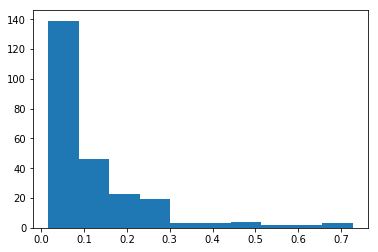

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:10000].numpy()
plt.hist(cred[suc_ind])

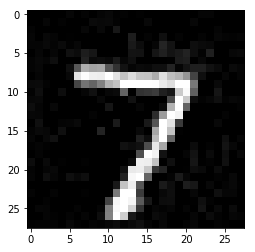

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [28]:
(x_adv.cpu() - x_test[:10000]).view(10000, -1).norm(2, 1).mean()

tensor(1.3970, grad_fn=<MeanBackward1>)

---

In [27]:
# Set all random seeds
exp_id = 0
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'train_mnist_cav_exp%d.h5' % exp_id
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [32]:
x_train = x_train.to(device)
x_test = x_test.to(device)
x_valid = x_valid.to(device)

In [28]:
net

ClassAuxVAE(
  (en_conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (en_conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (en_conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (en_fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU(inplace)
  (en_mu): Linear(in_features=128, out_features=20, bias=True)
  (en_logvar): Linear(in_features=128, out_features=20, bias=True)
  (de_fc1): Linear(in_features=20, out_features=128, bias=True)
  (de_fc2): Linear(in_features=128, out_features=1568, bias=True)
  (ax_fc1): Linear(in_features=20, out_features=128, bias=True)
  (ax_fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [59]:
layers = ['en_mu']
net = net.to(device)
with torch.no_grad():
    dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [60]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.964

(array([ 741., 1243.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8016.]),
 array([0.01683333, 0.11515   , 0.21346667, 0.31178333, 0.4101    ,
        0.50841667, 0.60673333, 0.70505   , 0.80336667, 0.90168333,
        1.        ]),
 <a list of 10 Patch objects>)

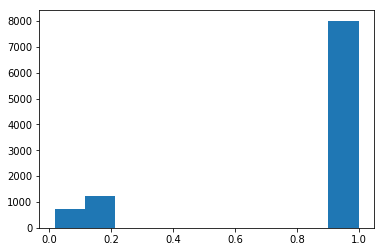

In [61]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [62]:
from lib.dknn_attack import DKNNAttack

attack = DKNNAttack()
x_adv = attack(dknn, x_test[:1000], y_test[:1000],
               guide_layer='en_mu', binary_search_steps=5,
               max_iterations=500, learning_rate=1e-1,
               initial_const=1, abort_early=True)

    step: 0; loss: -10.374; l2dist: 0.000
    step: 50; loss: -16.516; l2dist: 2.206
    step: 100; loss: -17.532; l2dist: 2.233
    step: 150; loss: -21.379; l2dist: 2.383
    step: 200; loss: -23.950; l2dist: 2.461
    step: 250; loss: -25.525; l2dist: 2.522
    step: 300; loss: -26.562; l2dist: 2.575
    step: 350; loss: -27.237; l2dist: 2.610
    step: 400; loss: -27.690; l2dist: 2.641
    step: 450; loss: -27.980; l2dist: 2.662
binary step: 0; number of successful adv: 732/1000
    step: 0; loss: -31.082; l2dist: 0.000
    step: 50; loss: -80.035; l2dist: 2.555
    step: 100; loss: -102.080; l2dist: 2.891
    step: 150; loss: -113.852; l2dist: 3.048
    step: 200; loss: -119.545; l2dist: 3.074
    step: 250; loss: -122.952; l2dist: 3.069
    step: 300; loss: -125.118; l2dist: 3.057
    step: 350; loss: -126.465; l2dist: 3.052
    step: 400; loss: -127.398; l2dist: 3.048
    step: 450; loss: -127.963; l2dist: 3.048
binary step: 1; number of successful adv: 1000/1000
    step: 0; lo

In [18]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum()

0

In [40]:
x.size()

torch.Size([1000, 128, 4, 4])

In [41]:
F.normalize(x.view(1000, -1), 2, 1).norm(2, 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

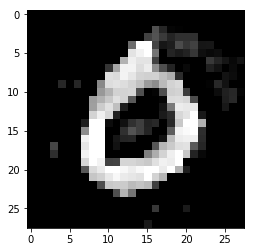

In [56]:
plt.imshow(x_adv[3].cpu().detach().numpy().squeeze(), cmap='gray')

In [20]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(2, 1).mean()

tensor(1.9813, grad_fn=<MeanBackward1>)

---
# Soft DkNN

In [ ]:
def attack_soft_dknn(dknn, x):
    
    train_reps = dknn.get_activations(dknn.x_train)[dknn.layers[0]]
    dknn.model

In [14]:
with torch.no_grad():
    train_reps = dknn.get_activations(dknn.x_train)[dknn.layers[0]]
    train_reps = F.normalize(train_reps.view(dknn.x_train.size(0), -1), 2, 1)
    test_reps = dknn.get_activations(x_test)[dknn.layers[0]]
    test_reps = F.normalize(test_reps.view(x_test.size(0), -1), 2, 1)

In [7]:
temp = 2e-2
k = 75

with torch.no_grad():
    logits = torch.empty((x_test.size(0), dknn.num_classes))
    for i, tr in enumerate(test_reps):
        cos = ((tr.unsqueeze(0) * train_reps).sum(1) / temp).exp()
#         cos = (tr.unsqueeze(0) * train_reps).sum(1)
        for label in range(dknn.num_classes):
#             logits[i, label] = cos[dknn.y_train == label].topk(k)[0].mean()
            logits[i, label] = cos[dknn.y_train == label].mean()

NameError: name 'test_reps' is not defined

---

## LID & Sensitivity

In [6]:
# spectral norm of jacobian and LID of basic model

layers = ['relu1', 'relu2', 'relu3', 'fc']
dknn = DKNNL2(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
              k=75, num_classes=10)

In [7]:
x = x_test.requires_grad_(True)[:1000]

In [8]:
norms = compute_spnorm(x, dknn, layers)
print(', '.join('%.4f' % i for i in norms.mean(0)))

3.5763, 12.8764, 26.2434, 13.5448


In [9]:
lid = np.zeros((x.size(0), len(layers)))
reps = dknn.get_activations(x, requires_grad=False)
train_reps = dknn.get_activations(x_train, requires_grad=False)

for l, layer in enumerate(layers):
    lid[:, l] = compute_lid(reps[layer], 
                         train_reps[layer], 
                         3000, 
                         exclude_self=False)
print(', '.join('%.4f' % i for i in lid.mean(0)))

12.5957, 11.1405, 8.5105, 4.0548


In [ ]:
# (maybe) spectral norm is not good for comparing between layers
# because of difference in dimension

In [6]:
# spectral norm of jacobian and LID of VAE (exp4)

layers = ['relu1', 'relu2', 'relu3', 'en_mu']
dknn = DKNNL2(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
              k=75, num_classes=10)

In [ ]:
x = x_test.requires_grad_(True)[:1000]

In [ ]:
norms = compute_spnorm(x, dknn, layers)
print(', '.join('%.4f' % i for i in norms.mean(0)))

In [ ]:
lid = np.zeros((x.size(0), len(layers)))
reps = dknn.get_activations(x, requires_grad=False)
train_reps = dknn.get_activations(x_train, requires_grad=False)

for l, layer in enumerate(layers):
    lid[:, l] = compute_lid(reps[layer], 
                         train_reps[layer], 
                         3000, 
                         exclude_self=False)
print(', '.join('%.4f' % i for i in lid.mean(0)))

In [10]:
from lib.foolbox_model import *

In [11]:
dknn_fb = DkNNFoolboxModel(dknn, (0, 1), 1, preprocessing=(0, 1))

In [45]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance, Linfinity 

criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.BoundaryAttack(
    model=dknn_fb, criterion=criterion, distance=distance)

In [46]:
attack_params = {
    'iterations': 10000,
    'max_directions': 25,
    'starting_point': None,
    'initialization_attack': None,
    'log_every_n_steps': 100,
    'spherical_step': 1.0,
    'source_step': 0.1,
    'step_adaptation': 1.5,
    'batch_size': 1,
    'tune_batch_size': True, 
    'threaded_rnd': True, 
    'threaded_gen': True, 
    'alternative_generator': False
}

num = 1
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, verbose=True, **attack_params)

Neither starting_point nor initialization_attack given. Falling back to BlendedUniformNoiseAttack for initialization.
Initial spherical_step = 1.00, source_step = 0.10
Using 4 threads to create random numbers
Step 0: 1.36508e-01, stepsizes = 1.0e+00/1.0e-01: 
  Boundary too non-linear, decreasing steps: 0.05 (100), 0.00 ( 5)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.00 ( 6)
Step 100: 8.79483e-02, stepsizes = 4.4e-01/4.4e-02:  (took 2.99109 seconds)
Initializing generation and prediction time measurements. This can take a few seconds.
Estimating optimal batch size
Time since beginning: 669.22764
   1.0% for generation (6.46957)
   15.3% for spherical prediction (102.47140)
   70.9% for prediction (474.42754)
   0.0% for hyperparameter update (0.01493)
   12.8% for the rest (85.84422)
current estimate of the time to generate a candidate depending on the batch size:
[2.55814007e-03 4.39345837e-04 2.04192268e-04 2.60367990e-04
 3.55072021e-04 5.48428959e-05 7.90917144e-05 

  Boundary too non-linear, decreasing steps: 0.12 (100), 0.14 (14)
  Success rate too low, decreasing source step:  0.22 (100), 0.13 (30)
Step 300: 3.50126e-02, stepsizes = 8.8e-02/3.9e-03:  (took 0.65270 seconds)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.05 (19)
  Success rate too low, decreasing source step:  0.28 ( 50), 0.00 (30)
Step 400: 2.67988e-02, stepsizes = 5.9e-02/1.7e-03: d. reduced by 0.35% (9.3189e-05) (took 0.67623 seconds)
Estimating optimal batch size
Time since beginning: 808.57654
   1.1% for generation (8.91197)
   14.2% for spherical prediction (115.18854)
   72.9% for prediction (589.44378)
   0.0% for hyperparameter update (0.04040)
   11.7% for the rest (94.99185)
current estimate of the time to generate a candidate depending on the batch size:
[2.55814007e-03 4.39345837e-04 2.04192268e-04 2.60367990e-04
 3.55072021e-04 5.48428959e-05 7.90917144e-05 8.69520009e-05
 9.42077166e-05 5.94210625e-05 3.85784906e-05 1.66851613e-04
 5.68945732e-05 1.289

Step 900: 1.61476e-02, stepsizes = 2.6e-02/3.4e-04: d. reduced by 0.07% (1.1068e-05) (took 0.72218 seconds)
  Boundary too non-linear, decreasing steps: 0.18 (100), 0.30 (30)
Step 1000: 1.56287e-02, stepsizes = 1.7e-02/2.3e-04: d. reduced by 0.05% (7.1404e-06) (took 0.80553 seconds)
Estimating optimal batch size
Time since beginning: 1099.91178
   1.3% for generation (13.83356)
   12.8% for spherical prediction (140.92117)
   75.2% for prediction (827.04217)
   0.0% for hyperparameter update (0.19105)
   10.7% for the rest (117.92383)
current estimate of the time to generate a candidate depending on the batch size:
[2.55814007e-03 4.08196449e-04 2.04192268e-04 2.60367990e-04
 3.55072021e-04 5.48428959e-05 7.90917144e-05 8.69520009e-05
 9.42077166e-05 5.94210625e-05 3.85784906e-05 1.66851613e-04
 5.68945732e-05 1.28919981e-04 9.55666436e-05 1.97105110e-05
 1.43760628e-05 2.79155778e-05 2.65139952e-05 1.94364786e-05
 2.82712534e-05 2.37837311e-05 1.48678152e-05 1.09945734e-05
 1.29926135

  Boundary too non-linear, decreasing steps: 0.03 (100), 0.33 ( 3)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.18 (22)
  Success rate too low, decreasing source step:  0.56 ( 25), 0.13 (30)
Step 1200: 1.50270e-02, stepsizes = 1.2e-02/1.0e-04: d. reduced by 0.02% (3.0507e-06) (took 0.83964 seconds)
  Success rate too low, decreasing source step:  0.30 (100), 0.17 (30)
Step 1300: 1.47830e-02, stepsizes = 1.2e-02/6.8e-05: d. reduced by 0.01% (2.0007e-06) (took 0.70453 seconds)
Estimating optimal batch size
Time since beginning: 1240.87653
   1.3% for generation (16.44455)
   12.4% for spherical prediction (153.30529)
   75.9% for prediction (941.94015)
   0.0% for hyperparameter update (0.29152)
   10.4% for the rest (128.89502)
current estimate of the time to generate a candidate depending on the batch size:
[2.55814007e-03 4.08196449e-04 2.04192268e-04 2.60367990e-04
 3.55072021e-04 5.48428959e-05 7.90917144e-05 8.69520009e-05
 9.42077166e-05 5.94210625e-05 3.85784906e-05

  Boundary too non-linear, decreasing steps: 0.18 (100), 0.20 (30)
  Success rate too low, decreasing source step:  0.20 ( 50), 0.13 (30)
Step 1800: 1.41669e-02, stepsizes = 5.1e-03/2.0e-05: d. reduced by 0.00% (5.6826e-07) (took 0.60293 seconds)
  Success rate too high, increasing source step: 0.40 (100), 0.57 (30)
  Success rate too low, decreasing source step:  0.43 (100), 0.07 (30)
Step 1900: 1.41043e-02, stepsizes = 5.1e-03/2.0e-05: d. reduced by 0.00% (5.6559e-07) (took 0.69565 seconds)
Estimating optimal batch size
Time since beginning: 1523.01799
   1.4% for generation (21.41045)
   11.8% for spherical prediction (179.06828)
   76.9% for prediction (1171.81344)
   0.0% for hyperparameter update (0.42228)
   9.9% for the rest (150.30354)
current estimate of the time to generate a candidate depending on the batch size:
[2.55814007e-03 5.31754805e-04 2.04192268e-04 2.60367990e-04
 3.55072021e-04 5.48428959e-05 7.90917144e-05 8.69520009e-05
 9.42077166e-05 5.94210625e-05 3.85784906

  Boundary too non-linear, decreasing steps: 0.15 (100), 0.23 (30)
  Success rate too low, decreasing source step:  0.20 ( 74), 0.13 (30)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.40 (15)
Step 2400: 1.39531e-02, stepsizes = 1.5e-03/4.0e-06: d. reduced by 0.00% (1.1030e-07) (took 0.72685 seconds)
  Success rate too high, increasing source step: 0.38 ( 72), 0.63 (30)
  Success rate too low, decreasing source step:  0.33 (100), 0.17 (30)
Step 2500: 1.39416e-02, stepsizes = 1.5e-03/4.0e-06: d. reduced by 0.00% (1.1042e-07) (took 0.82726 seconds)
  Success rate too high, increasing source step: 0.41 (100), 0.53 (30)
  Boundary too non-linear, decreasing steps: 0.18 (100), 0.24 (17)
  Success rate too low, decreasing source step:  0.27 ( 49), 0.17 (30)
Step 2600: 1.39340e-02, stepsizes = 1.0e-03/2.6e-06: d. reduced by 0.00% (7.3738e-08) (took 0.64675 seconds)
  Boundary too non-linear, decreasing steps: 0.13 (100), 0.52 (21)
  Success rate too high, increasing source step: 0

  Success rate too low, decreasing source step:  0.27 ( 75), 0.17 (30)
  Boundary too non-linear, decreasing steps: 0.18 (100), 0.40 (10)
  Boundary too non-linear, decreasing steps: 0.13 (100), 0.30 (30)
Step 3200: 1.39172e-02, stepsizes = 8.9e-05/2.3e-07:  (took 0.52095 seconds)
  Boundary too non-linear, decreasing steps: 0.11 (100), 0.20 (30)
  Boundary too non-linear, decreasing steps: 0.15 (100), 0.37 (30)
Step 3300: 1.39169e-02, stepsizes = 4.0e-05/1.0e-07:  (took 0.54615 seconds)
  Success rate too low, decreasing source step:  0.28 ( 50), 0.13 (30)
Step 3320: 1.39168e-02, stepsizes = 4.0e-05/6.9e-08: 
Looks like attack has converged after 3321 steps for the first time. Resetting steps to be sure.
  Boundary too non-linear, decreasing steps: 0.14 (100), -1.00 ( 0)
  Boundary too non-linear, decreasing steps: 0.00 (100), -1.00 ( 0)
  Boundary too non-linear, decreasing steps: 0.00 (100), -1.00 ( 0)
  Boundary too non-linear, decreasing steps: 0.00 (100), -1.00 ( 0)
  Boundary to

Step 3470: 1.39168e-02, stepsizes = 1.0e-05/2.0e-09: 
Looks like attack has converged after 3471 steps, 60 remaining
  Boundary too linear, increasing steps:     0.59 (100), 0.23 (30)
Step 3471: 1.39168e-02, stepsizes = 1.5e-05/3.1e-09: 
Looks like attack has converged after 3472 steps, 59 remaining
Step 3472: 1.39168e-02, stepsizes = 1.5e-05/3.1e-09: 
Looks like attack has converged after 3473 steps, 58 remaining
  Success rate too high, increasing source step: 0.68 ( 50), 0.53 (30)
Step 3473: 1.39168e-02, stepsizes = 1.5e-05/4.6e-09: 
Looks like attack has converged after 3474 steps, 57 remaining
Step 3474: 1.39168e-02, stepsizes = 1.5e-05/4.6e-09: 
Looks like attack has converged after 3475 steps, 56 remaining
  Boundary too linear, increasing steps:     0.67 (100), 0.77 (30)
  Success rate too high, increasing source step: 0.67 (100), 0.77 (30)
Step 3475: 1.39168e-02, stepsizes = 2.3e-05/1.0e-08: 
Looks like attack has converged after 3476 steps, 55 remaining
Step 3476: 1.39168e-02

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/foolbox/attacks/boundary_attack.py:357: UserWarning: Attack has not converged!
  warnings.warn('Attack has not converged!')


  Boundary too non-linear, decreasing steps: 0.07 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
Step 3600: 1.39167e-02, stepsizes = 3.4e-05/1.2e-07:  (took 0.44585 seconds)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.27 (30)
Step 3640: 1.39167e-02, stepsizes = 2.3e-05/7.8e-08: 
Looks like attack has converged after 3641 steps for the first time. Resetting steps to be sure.
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.01 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasing steps: 0.00 (100), 0.27 (30)
  Boundary too non-linear, decreasi

Step 3792: 1.39167e-02, stepsizes = 3.1e-09/2.7e-10: 
Looks like attack has converged after 3793 steps, 59 remaining
Step 3793: 1.39167e-02, stepsizes = 3.1e-09/2.7e-10: 
Looks like attack has converged after 3794 steps, 58 remaining
  Success rate too low, decreasing source step:  0.16 ( 50), 0.00 (30)
Step 3794: 1.39167e-02, stepsizes = 3.1e-09/1.8e-10: 
Looks like attack has converged after 3795 steps, 57 remaining
Step 3795: 1.39167e-02, stepsizes = 3.1e-09/1.8e-10: 
Looks like attack has converged after 3796 steps, 56 remaining
  Boundary too non-linear, decreasing steps: 0.16 (100), 0.00 ( 8)
Step 3796: 1.39167e-02, stepsizes = 2.0e-09/1.2e-10: 
Looks like attack has converged after 3797 steps, 55 remaining
Step 3797: 1.39167e-02, stepsizes = 2.0e-09/1.2e-10: 
Looks like attack has converged after 3798 steps, 54 remaining
Step 3798: 1.39167e-02, stepsizes = 2.0e-09/1.2e-10: 
Looks like attack has converged after 3799 steps, 53 remaining
Step 3799: 1.39167e-02, stepsizes = 2.0e-09

In [47]:
y_pred = dknn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

1.0


In [48]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

3.3031292


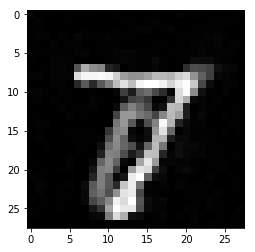

In [49]:
plt.imshow(x_adv[0].reshape(28, 28), cmap='gray')

In [30]:
attack_params = {
    'iterations': 10000,
    'max_directions': 25,
    'starting_point': None,
    'initialization_attack': None,
    'log_every_n_steps': 100,
    'spherical_step': 0.5,
    'source_step': 0.05,
    'step_adaptation': 1.5,
    'batch_size': 1,
    'tune_batch_size': True, 
    'threaded_rnd': True, 
    'threaded_gen': True, 
    'alternative_generator': False
}

num = 1
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, verbose=True, **attack_params)

Neither starting_point nor initialization_attack given. Falling back to BlendedUniformNoiseAttack for initialization.
Initial spherical_step = 0.50, source_step = 0.05
Using 4 threads to create random numbers
Step 0: 1.18628e-01, stepsizes = 5.0e-01/5.0e-02: 
  Boundary too non-linear, decreasing steps: 0.02 (100), 0.33 ( 3)
  Boundary too non-linear, decreasing steps: 0.06 (100), 0.22 ( 9)
Step 100: 5.23035e-02, stepsizes = 2.2e-01/2.2e-02:  (took 6.82330 seconds)
Initializing generation and prediction time measurements. This can take a few seconds.
During initialization, a better adversarial has been found. Continuing from there.
Estimating optimal batch size
Time since beginning: 769.55649
   0.8% for generation (6.29083)
   16.2% for spherical prediction (125.01746)
   69.0% for prediction (531.29734)
   0.0% for hyperparameter update (0.00170)
   13.9% for the rest (106.94915)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 1.61886

  Boundary too non-linear, decreasing steps: 0.19 (100), 0.03 (30)
  Success rate too low, decreasing source step:  0.19 (100), 0.03 (30)
  Boundary too non-linear, decreasing steps: 0.16 (100), 0.18 (22)
Step 300: 2.30754e-02, stepsizes = 4.4e-02/2.0e-03:  (took 1.00404 seconds)
  Success rate too low, decreasing source step:  0.30 ( 50), 0.13 (30)
Step 400: 1.86159e-02, stepsizes = 4.4e-02/1.3e-03: d. reduced by 0.26% (4.8519e-05) (took 0.63047 seconds)
Estimating optimal batch size
Time since beginning: 920.39514
   0.9% for generation (8.68309)
   15.0% for spherical prediction (138.45500)
   71.3% for prediction (656.50427)
   0.0% for hyperparameter update (0.03242)
   12.7% for the rest (116.72037)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 1.61886215e-04 4.87354067e-04 1.38908625e-04
 8.61072540e-05 1.05440617e-04 1.82516721e-04 5.93326986e-05
 5.39355808e-05 3.60035896e-05 9.26108400e-05 7.16265705e-05
 2.38432687e-05 3.01

  Boundary too linear, increasing steps:     0.51 (100), 0.37 (30)
  Success rate too low, decreasing source step:  0.21 ( 71), 0.17 (30)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.44 ( 9)
Step 900: 1.10514e-02, stepsizes = 1.3e-02/1.7e-04: d. reduced by 0.05% (5.6806e-06) (took 0.48744 seconds)
  Success rate too high, increasing source step: 0.38 (100), 0.63 (30)
  Success rate too low, decreasing source step:  0.37 (100), 0.10 (30)
Step 1000: 1.06682e-02, stepsizes = 1.3e-02/1.7e-04:  (took 1.29117 seconds)
Estimating optimal batch size
Time since beginning: 1220.04727
   1.1% for generation (13.49967)
   13.6% for spherical prediction (166.38187)
   73.8% for prediction (900.47613)
   0.0% for hyperparameter update (0.15246)
   11.4% for the rest (139.53713)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 1.61886215e-04 4.87354067e-04 3.13494574e-04
 8.61072540e-05 1.05440617e-04 1.82516721e-04 5.93326986e-05
 5.3935

  Success rate too low, decreasing source step:  0.31 (100), 0.10 (30)
  Boundary too non-linear, decreasing steps: 0.19 (100), 0.30 (30)
Step 1500: 9.54275e-03, stepsizes = 8.7e-03/7.6e-05: d. reduced by 0.02% (1.4531e-06) (took 0.69538 seconds)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.47 (30)
  Success rate too high, increasing source step: 0.51 ( 69), 0.57 (30)
Step 1600: 9.44063e-03, stepsizes = 5.8e-03/7.6e-05: d. reduced by 0.02% (1.4374e-06) (took 0.65566 seconds)
Estimating optimal batch size
Time since beginning: 1524.51953
   1.2% for generation (18.25969)
   12.7% for spherical prediction (193.50963)
   75.4% for prediction (1149.34780)
   0.0% for hyperparameter update (0.27283)
   10.7% for the rest (163.12957)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 8.94709213e-04 4.87354067e-04 2.53410491e-04
 8.61072540e-05 1.05440617e-04 1.82516721e-04 5.93326986e-05
 5.39355808e-05 3.60035896e-05 9.26108400e-0

  Success rate too high, increasing source step: 0.47 (100), 0.63 (30)
  Boundary too non-linear, decreasing steps: 0.16 (100), 0.17 (30)
  Success rate too low, decreasing source step:  0.16 (100), 0.17 (30)
Step 1800: 9.30334e-03, stepsizes = 2.6e-03/2.3e-05: d. reduced by 0.01% (9.4427e-07) (took 0.79132 seconds)
Estimating optimal batch size
Time since beginning: 1632.05951
   1.2% for generation (19.98013)
   12.4% for spherical prediction (202.64156)
   75.8% for prediction (1237.83260)
   0.0% for hyperparameter update (0.32096)
   10.5% for the rest (171.28426)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 8.94709213e-04 4.87354067e-04 2.12542666e-04
 8.61072540e-05 1.05440617e-04 1.82516721e-04 5.93326986e-05
 5.39355808e-05 3.60035896e-05 9.26108400e-05 7.16265705e-05
 2.38432687e-05 3.01331890e-05 4.22329373e-05 3.89022753e-05
 2.26406903e-05 1.50328801e-05 3.53414266e-05 3.80820036e-05
 1.60338336e-05 1.31696709e-05 1.4076

Step 2100: 9.21258e-03, stepsizes = 1.7e-03/2.3e-05: d. reduced by 0.00% (4.1564e-07) (took 0.73708 seconds)
Estimating optimal batch size
Time since beginning: 1792.42641
   1.2% for generation (22.34715)
   12.1% for spherical prediction (216.67831)
   76.4% for prediction (1369.85085)
   0.0% for hyperparameter update (0.39626)
   10.2% for the rest (183.15384)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 8.94709213e-04 4.87354067e-04 1.87010542e-04
 8.61072540e-05 1.05440617e-04 1.82516721e-04 5.93326986e-05
 5.39355808e-05 3.60035896e-05 9.26108400e-05 7.16265705e-05
 2.38432687e-05 3.01331890e-05 4.22329373e-05 3.89022753e-05
 2.26406903e-05 1.50328801e-05 3.53414266e-05 3.80820036e-05
 1.59711216e-05 1.31696709e-05 1.40768963e-05 2.06563208e-05
 1.31719256e-05]
current estimate of the time to get predictions for a candidate depending on the batch size:
[0.21450113 0.15854522 0.10157831 0.08408723 0.06035723 0.05856826
 0.05419

  Success rate too high, increasing source step: 0.48 (100), 0.80 (30)
Step 2300: 9.18427e-03, stepsizes = 1.1e-03/1.5e-05:  (took 0.73214 seconds)
  Success rate too low, decreasing source step:  0.24 (100), 0.10 (30)
  Boundary too non-linear, decreasing steps: 0.17 (100), 0.30 (30)
Step 2400: 9.16937e-03, stepsizes = 7.6e-04/6.7e-06: d. reduced by 0.00% (1.8384e-07) (took 0.86292 seconds)
Estimating optimal batch size
Time since beginning: 1938.11571
   1.3% for generation (24.89770)
   11.9% for spherical prediction (229.76535)
   76.8% for prediction (1488.70167)
   0.0% for hyperparameter update (0.45575)
   10.0% for the rest (194.29523)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 8.94709213e-04 4.87354067e-04 1.87010542e-04
 8.61072540e-05 1.05440617e-04 1.82516721e-04 5.93326986e-05
 5.39355808e-05 3.60035896e-05 9.26108400e-05 7.16265705e-05
 2.38432687e-05 3.01331890e-05 4.22329373e-05 3.89022753e-05
 2.26406903e-05 1.503

  Boundary too linear, increasing steps:     0.63 (100), 0.50 (30)
  Boundary too non-linear, decreasing steps: 0.18 (100), 0.40 (30)
Step 2900: 9.12883e-03, stepsizes = 5.1e-04/4.5e-06: d. reduced by 0.00% (8.1391e-08) (took 0.58794 seconds)
Step 3000: 9.12257e-03, stepsizes = 5.1e-04/4.5e-06: d. reduced by 0.00% (8.1249e-08) (took 0.76017 seconds)
Step 3100: 9.11550e-03, stepsizes = 5.1e-04/4.5e-06: d. reduced by 0.00% (8.1233e-08) (took 0.87935 seconds)
  Success rate too low, decreasing source step:  0.24 (100), 0.13 (30)
  Success rate too high, increasing source step: 0.36 (100), 0.60 (30)
  Success rate too low, decreasing source step:  0.38 (100), 0.17 (30)
Step 3200: 9.11036e-03, stepsizes = 5.1e-04/3.0e-06:  (took 0.89250 seconds)
  Success rate too high, increasing source step: 0.39 (100), 0.73 (30)
Step 3300: 9.10530e-03, stepsizes = 5.1e-04/4.5e-06: d. reduced by 0.00% (8.1109e-08) (took 0.71822 seconds)
  Success rate too low, decreasing source step:  0.30 (100), 0.13 (30

  Boundary too non-linear, decreasing steps: 0.19 (100), 0.17 (30)
  Success rate too low, decreasing source step:  0.19 (100), 0.17 (30)
  Success rate too high, increasing source step: 0.51 ( 75), 0.53 (30)
Step 4100: 9.07145e-03, stepsizes = 1.0e-04/8.8e-07:  (took 0.76283 seconds)
  Boundary too non-linear, decreasing steps: 0.13 (100), 0.15 (13)
  Boundary too non-linear, decreasing steps: 0.04 (100), 0.12 (17)
  Boundary too non-linear, decreasing steps: 0.12 (100), 0.10 (29)
  Success rate too low, decreasing source step:  0.12 ( 25), 0.07 (30)
Step 4200: 9.07117e-03, stepsizes = 3.0e-05/1.7e-07:  (took 0.90357 seconds)
Estimating optimal batch size
Time since beginning: 2875.01473
   1.4% for generation (39.73211)
   11.0% for spherical prediction (316.08568)
   78.6% for prediction (2259.24545)
   0.0% for hyperparameter update (0.81603)
   9.0% for the rest (259.13545)
current estimate of the time to generate a candidate depending on the batch size:
[2.56306898e-03 6.63739184

Step 4451: 9.07102e-03, stepsizes = 5.2e-08/3.5e-08: 
Looks like attack has converged after 4452 steps, 91 remaining
Step 4452: 9.07102e-03, stepsizes = 5.2e-08/3.5e-08: 
Looks like attack has converged after 4453 steps, 90 remaining
Step 4453: 9.07102e-03, stepsizes = 5.2e-08/3.5e-08: 
Looks like attack has converged after 4454 steps, 89 remaining
  Boundary too non-linear, decreasing steps: 0.10 (100), 0.00 (28)
Step 4454: 9.07102e-03, stepsizes = 3.5e-08/2.3e-08: 
Looks like attack has converged after 4455 steps, 88 remaining
  Success rate too low, decreasing source step:  0.08 ( 25), 0.00 (30)
Step 4455: 9.07102e-03, stepsizes = 3.5e-08/1.5e-08: 
Looks like attack has converged after 4456 steps, 87 remaining
Step 4456: 9.07102e-03, stepsizes = 3.5e-08/1.5e-08: 
Looks like attack has converged after 4457 steps, 86 remaining
Step 4457: 9.07102e-03, stepsizes = 3.5e-08/1.5e-08: 
Looks like attack has converged after 4458 steps, 85 remaining
  Boundary too non-linear, decreasing steps

Step 4512: 9.07102e-03, stepsizes = 6.9e-09/7.9e-11: 
Looks like attack has converged after 4513 steps, 30 remaining
Step 4513: 9.07102e-03, stepsizes = 6.9e-09/7.9e-11: 
Looks like attack has converged after 4514 steps, 29 remaining
  Success rate too low, decreasing source step:  0.32 ( 50), 0.00 (30)
Step 4514: 9.07102e-03, stepsizes = 6.9e-09/5.3e-11: 
Looks like attack has converged after 4515 steps, 28 remaining
Step 4515: 9.07102e-03, stepsizes = 6.9e-09/5.3e-11: 
Looks like attack has converged after 4516 steps, 27 remaining
Step 4516: 9.07102e-03, stepsizes = 6.9e-09/5.3e-11: 
Looks like attack has converged after 4517 steps, 26 remaining
  Success rate too low, decreasing source step:  0.39 (100), 0.00 (30)
Step 4517: 9.07102e-03, stepsizes = 6.9e-09/3.5e-11: 
Looks like attack has converged after 4518 steps, 25 remaining
Step 4518: 9.07102e-03, stepsizes = 6.9e-09/3.5e-11: 
Looks like attack has converged after 4519 steps, 24 remaining
Step 4519: 9.07102e-03, stepsizes = 6.9

In [31]:
y_pred = dknn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

0.0


In [32]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

2.6667733


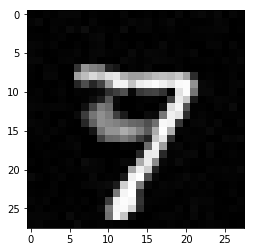

In [33]:
plt.imshow(x_adv[0].reshape(28, 28), cmap='gray')

In [34]:
y_pred.argmax(1)

array([9])

In [12]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance, Linfinity 

criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.SinglePixelAttack(
    model=dknn_fb, criterion=criterion, distance=distance)

In [18]:
num = 10
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, max_pixels=784)

In [19]:
y_pred = dknn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

0.2


In [21]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist)

[nan nan nan nan nan nan nan nan nan nan]


In [ ]:
# single-pixel attack never succeeds

In [31]:
from foolbox.criteria import Misclassification
from foolbox.distances import MeanSquaredDistance, Linfinity 

criterion = Misclassification()
distance = MeanSquaredDistance
# distance = Linfinity

attack = foolbox.attacks.LocalSearchAttack(
    model=dknn_fb, criterion=criterion, distance=distance)

In [35]:
num = 10
x_adv = np.zeros_like(x_test[:num].numpy())
for i in range(num):
    x_adv[i] = attack(x_test[i].numpy(), label=y_test[i].numpy(), 
                      unpack=True, r=1.5, p=10.0, d=5, t=5, R=150)

In [36]:
y_pred = dknn.classify(torch.tensor(x_adv))
print((y_pred.argmax(1) == y_test[:num].numpy()).sum() / num)

0.1


In [37]:
dist = np.sqrt(np.sum((x_adv - x_test[:num].numpy())**2, (1, 2, 3)))
print(dist.mean())

nan


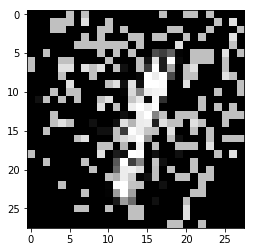

In [39]:
plt.imshow(x_adv[5].reshape(28, 28), cmap='gray')

In [ ]:
# local-search attack only works 1/10 and noise is very large

In [ ]:
layers = ['relu1', 'relu2', 'relu3', 'fc']
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, num_classes=10)

In [50]:
# Verify Lipschitzness

x = x_test.requires_grad_(True)[:1000]

norms = compute_spnorm(x, dknn, layers)
print(', '.join('%.4f' % i for i in norms.mean(0)))

0.9607, 0.8579, 0.5358, 0.5033


In [51]:
print(', '.join('%.4f' % i for i in norms.mean(0)))

0.9607, 0.8579, 0.5358, 0.5033


---

In [ ]:
y_pred = net(x_test)

tensor(0.0235, device='cuda:0')


(array([3.297e+03, 2.081e+03, 1.830e+03, 1.407e+03, 8.290e+02, 3.950e+02,
        1.240e+02, 3.300e+01, 3.000e+00, 1.000e+00]),
 array([5.9045851e-07, 1.1226014e-02, 2.2451438e-02, 3.3676863e-02,
        4.4902287e-02, 5.6127708e-02, 6.7353129e-02, 7.8578554e-02,
        8.9803979e-02, 1.0102940e-01, 1.1225483e-01], dtype=float32),
 <a list of 10 Patch objects>)

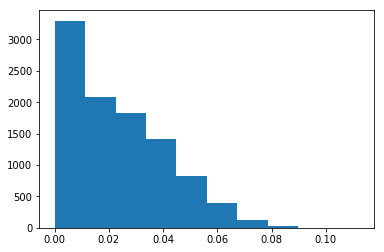

In [37]:
gap = y_pred.max(1)[0] - y_pred.sort()[0][:, -2]
print(gap.mean().data)
plt.hist(gap.cpu().detach().numpy())

In [7]:
def find_guide_samples(dknn, x, label, k=1, layer='relu1'):
    """
    find k nearest neighbors of the same class (not equal to y_Q) but
    closest to Q
    """
    num_classes = dknn.num_classes
    nn = torch.zeros((k, ) + x.size()).permute(1, 0, 2, 3, 4)
    D, I = dknn.get_neighbors(
        x, k=dknn.x_train.size(0), layers=[layer])[0]

    for i, (d, ind) in enumerate(zip(D, I)):
        mean_dist = np.zeros((num_classes, ))
        for j in range(num_classes):
            mean_dist[j] = np.mean(
                d[np.where(dknn.y_train[ind] == j)[0]][:k])
        # TODO: this may depend on the index used
        mean_dist[label[i]] += 1e20
        nearest_label = mean_dist.argmin()
        # mean_dist[label[i]] -= INFTY
        # nearest_label = mean_dist.argmax()
        nn_ind = np.where(dknn.y_train[ind] == nearest_label)[0][:k]
        nn[i] = dknn.x_train[ind[nn_ind]]

    return nn


def find_nn_diff_class(x_train, y_train, x, label, num_classes=10):
    """
    find k nearest neighbors of the same class (not equal to y_Q) but
    closest to Q
    """
    nn = torch.zeros_like(x)

    for i in range(x.size(0)):
        d = ((x[i].unsqueeze(0) - x_train)**2).view(x_train.size(0), -1).sum(1)
        sorted_ind = d.argsort()
        for j in range(x_train.size(0)):
            if label[i] != y_train[sorted_ind[j]]:
                nn[i] = x_train[sorted_ind[j]]
                break
    return nn

In [18]:
layers = ['relu3']
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=1, num_classes=10)

In [19]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.8868


In [20]:
rep_train = dknn.get_activations(x_train, requires_grad=False, device='cpu')[layers[0]]
rep_test = dknn.get_activations(x_test, requires_grad=False, device='cpu')[layers[0]]
rep_valid = dknn.get_activations(x_valid, requires_grad=False, device='cpu')[layers[0]]

In [21]:
knn = KNNL2(rep_train, y_train, rep_valid, y_valid, k=1, num_classes=10)

In [22]:
rep_nn = knn.find_nn_diff_class(rep_test, y_test)
rep_adv = knn.get_min_dist(rep_test, y_test, rep_nn, iterations=10)

In [23]:
dist = ((rep_test - rep_nn)**2).view(rep_test.size(0), -1).sum(1).sqrt()

In [24]:
dist.mean()

tensor(0.4930)

(array([ 195., 1660., 3101., 2666., 1381.,  600.,  265.,  100.,   23.,
           9.]),
 array([0.15380737, 0.26018655, 0.36656573, 0.47294492, 0.57932407,
        0.6857033 , 0.7920824 , 0.89846164, 1.0048409 , 1.11122   ,
        1.2175992 ], dtype=float32),
 <a list of 10 Patch objects>)

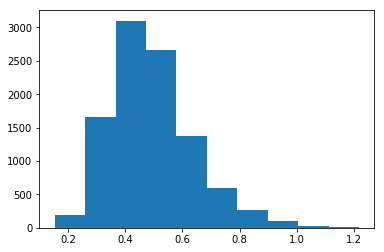

In [25]:
plt.hist(dist.cpu().detach().numpy())

In [26]:
perts = [1, 2, 3]
a = []
for pert in perts:
    a.append((dist.cpu().detach().numpy() > math.sqrt(2) * pert).mean())
print(a)

[0.0, 0.0, 0.0]


---

In [40]:
from lib.knn import KNNL2

knn = KNNL2(x_train, y_train, x_valid, y_valid, k=1, num_classes=10)

In [41]:
y_pred = knn.classify(x_test)
print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9683


In [42]:
x_nn = knn.find_nn_diff_class(x_test, y_test)
x_adv = knn.get_min_dist(x_test, y_test, x_nn, iterations=10)

In [43]:
dist = ((x_adv - x_test)**2).view(x_test.size(0), -1).sum(1).sqrt()

In [44]:
dist.mean()

tensor(1.8145)

(array([ 679.,  736., 1334., 2089., 2505., 1551.,  776.,  288.,   38.,
           4.]),
 array([2.7532987e-03, 4.6384671e-01, 9.2494017e-01, 1.3860335e+00,
        1.8471270e+00, 2.3082204e+00, 2.7693138e+00, 3.2304072e+00,
        3.6915007e+00, 4.1525941e+00, 4.6136875e+00], dtype=float32),
 <a list of 10 Patch objects>)

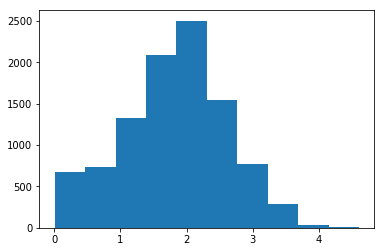

In [45]:
plt.hist(dist.cpu().detach().numpy())

In [47]:
pert = 3
(dist.cpu().detach().numpy() > math.sqrt(2) * pert).mean()

0.0003

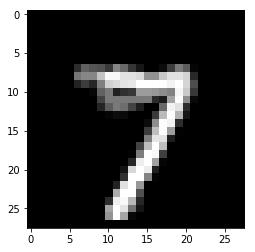

In [49]:
plt.imshow(x_adv[0].numpy().reshape(28, 28), cmap='gray')